https://mlarchive.com/deep-learning/variational-autoencoders-a-vanilla-implementation/

https://towardsdatascience.com/conditional-variational-autoencoders-for-text-to-image-generation-1996da9cefcb

### Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchmetrics.image.fid import FrechetInceptionDistance
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns
import wandb

### Set Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Device Used: cuda


In [3]:
saved_model_folder = "./saved_models"
os.makedirs(saved_model_folder, exist_ok=True)

### Data Loading and Processing

In [4]:
class AFHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: path of the parent directory that contains images.
        transforms: augmentations applied to the images (can be none or more).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_mapping = {}
        
        extensions = (".jpg", ".jpeg", ".png")
        # go through all sub-directories
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            full_path = os.path.join(root_dir, category)
            if os.path.exists(full_path):
                self.class_mapping[label] = category
                for img_name in os.listdir(full_path):
                    if img_name.endswith(extensions):
                        self.image_paths.append(os.path.join(full_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
# Dataset Hyperparameters
img_size = 64
batch_size = 64

# dataset paths
train_dir = '/home/user/javeda1/stargan-v2/data/afhq/train'
val_dir = '/home/user/javeda1/stargan-v2/data/afhq/val'

### Define augmentations

In [6]:
transform = transforms.Compose([
    
        # transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.Resize((img_size, img_size)), # image is downsampled to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [7]:
# Load the train and val dataset
train_dataset = AFHQDataset(root_dir=train_dir, transform=transform)
val_dataset = AFHQDataset(root_dir=val_dir, transform=transform)

# DataLoaders for train and val sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)

print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")

Train dataset size: 14630
Validation dataset size: 1500


### Visualize Dataset

In [8]:
def visualize_dataset(dataloader, num_images=12):
    """
    Visualizes a given number of images from the given data loader.
    """
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    class_mapping = dataloader.dataset.class_mapping
    
    # creates a suitable grid
    # grid_size = int(np.ceil(np.sqrt(num_images)))
    num_rows = int(np.sqrt(num_images))
    num_cols = int(np.ceil(num_images / num_rows))
    # print(num_cols, num_rows)
    plt.figure(figsize=(6, 6))
    plt.suptitle("Sample images from AFHQ dataset")
    
    for idx in range(min(num_images, len(images))):
        plt.subplot(num_rows, num_cols, idx + 1)
        
        img = images[idx].permute(1, 2, 0).numpy()
        max_val = np.max(img)
        min_val = np.min(img)
        img = (img - min_val) / (max_val - min_val)
        
        plt.imshow(img)
        plt.title(f'Class: {class_mapping[labels[idx].item()]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

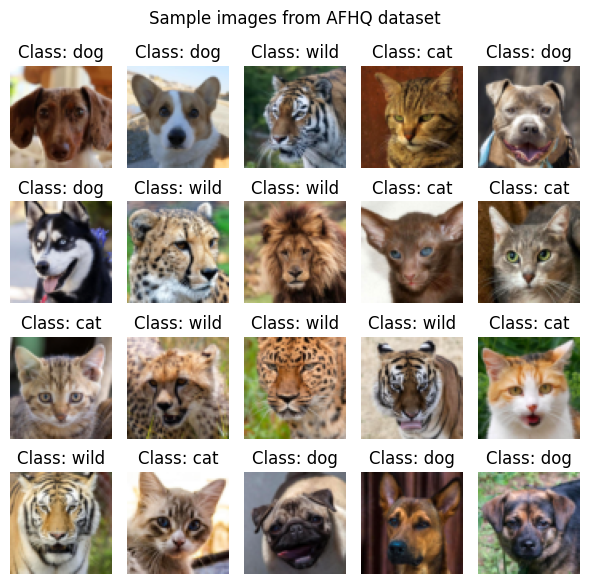

In [9]:
visualize_dataset(train_loader, num_images=20)

### Training and Validation Code

In [10]:
def vae_loss_function(recon_x, x, mu, log_var, kl_weight=1):
    """
    Calculates the VAE loss as a combination of 
    reconstruction loss and KL divergence, 
    scaled by a weight.
    """
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_divergence * kl_weight, recon_loss, kl_divergence

def train_vae(model, train_loader, optimizer, kl_weight, device):
    """
    Trains the Variational Autoencoder (VAE) for one epoch on the given training data loader.
    """
    model.train()
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    for inputs, _ in train_loader:  #labels not used
        inputs = inputs.to(device)
        optimizer.zero_grad()
        recon_x, mu, log_var = model(inputs)
        loss, recon_loss, kl_loss = vae_loss_function(recon_x, inputs, mu, log_var, kl_weight)
        loss.backward()
        optimizer.step()
        
        # Collect all losses
        running_loss += loss.item()
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()
        
    dataset_size = len(train_loader.dataset)
    return {
        'total_loss': running_loss / dataset_size,
        'recon_loss': running_recon_loss / dataset_size,
        'kl_loss': running_kl_loss / dataset_size
    }

def evaluate_vae(model, val_loader, kl_weight, device):
    """
    Evaluates the Variational Autoencoder (VAE) on the validation dataset after each epoch.
    """
    model.eval()
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            recon_x, mu, log_var = model(inputs)
            loss, recon_loss, kl_loss = vae_loss_function(recon_x, inputs, mu, log_var, kl_weight)
            
            # Collect all losses
            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()
            
    dataset_size = len(val_loader.dataset)
    return {
        'total_loss': running_loss / dataset_size,
        'recon_loss': running_recon_loss / dataset_size,
        'kl_loss': running_kl_loss / dataset_size
    }

def run_vae_training(
    model, train_loader, val_loader, device, num_epochs, learning_rate=0.001, 
    project="vae-training", name="vae_run", kl_weight=0.1, step_size=30, gamma=0.1):

    """Train and evaluate the model for a given number of epochs with W&B logging"""

    print(f"Training Name: {name}")
    print(f"Total num. of Epochs: {num_epochs}")
    print(f"Learning Rate: {learning_rate}")
    print(f"KL Weight used for Loss function: {kl_weight}\n")
    
    # Sample a batch for visualization ( used here to make it same for every epoch)
    inputs, _ = next(iter(train_loader))
    inputs = inputs.to(device)
    
    # Initialize W&B logging
    wandb.init(project=project, name=name, 
               config={
                   "learning_rate": learning_rate,
                   "num_epochs": num_epochs,
                   "step_size": step_size,
                   "gamma": gamma,
                   "kl_weight": kl_weight
               })
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # Optimizer
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # Learning rate scheduler
    
    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_metrics = train_vae(model, train_loader, optimizer, kl_weight, device)
        # Evaluate after each epoch
        val_metrics = evaluate_vae(model, val_loader, kl_weight, device)
        
        current_lr = scheduler.get_last_lr()[0]
        scheduler.step()

        # Log images to W&B
        with torch.no_grad():
            # # Sample a small batch for visualization
            # inputs, _ = next(iter(train_loader))
            # inputs = inputs[:32].to(device)
            recon_x, _, _ = model(inputs)

            # Normalize and convert to image format
            recon_x = recon_x.view(-1, *inputs.shape[1:])
            recon_grid = make_grid(recon_x.cpu().detach() * 0.5 + 0.5, normalize=True, pad_value=1, padding=10)
            original_grid = make_grid(inputs.cpu().detach() * 0.5 + 0.5, normalize=True, pad_value=1, padding=10)
    
        # Log all data to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train/total_loss": train_metrics['total_loss'],
            "train/recon_loss": train_metrics['recon_loss'],
            "train/kl_loss": train_metrics['kl_loss'],
            "val/total_loss": val_metrics['total_loss'],
            "val/recon_loss": val_metrics['recon_loss'],
            "val/kl_loss": val_metrics['kl_loss'],
            "learning_rate": current_lr,
            "original_images": wandb.Image(original_grid),
            "reconstructed_images": wandb.Image(recon_grid),
        })
        
        # # Print stats after each epoch
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Learning Rate: {current_lr:.6f}")
        print(f"Train - Total: {train_metrics['total_loss']:.4f}, "
              f"Recon: {train_metrics['recon_loss']:.4f}, "
              f"KL: {train_metrics['kl_loss']:.4f}")
        print(f"Eval  - Total: {val_metrics['total_loss']:.4f}, "
              f"Recon: {val_metrics['recon_loss']:.4f}, "
              f"KL: {val_metrics['kl_loss']:.4f}")
    
    # End W&B run
    wandb.finish()
    
    return model

### FID Score

In [64]:
def compute_fid_score(model, data_loader, device, max_samples=1000):
    """
    Computes the Fréchet Inception Distance (FID) between real and generated data.
    Taken from : https://lightning.ai/docs/torchmetrics/stable/image/frechet_inception_distance.html
    """
    fid = FrechetInceptionDistance(feature=2048).to(device)  # Use InceptionV3(default) features
    model.eval()
    
    total_samples = 0
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)

            # Generate reconstructions
            recon_x, _, _ = model(inputs)

            # Convert images to uint8 and scale to [0, 255]
            inputs = (inputs * 255).byte()  
            recon_x = (recon_x * 255).byte()

            fid.update(inputs, real=True)
            fid.update(recon_x, real=False)

            total_samples += inputs.size(0)
            # if total_samples >= max_samples:
            #     break  # Stop after reaching the sample limit
    
    # Compute the FID score
    fid_score = fid.compute().item()
    return fid_score

#### Load saved model

In [65]:
def load_model(model_path):
    """
    Load a saved model
    """
    model = torch.load(model_path)
    return model

### Result visualizations

In [13]:
def visualize_reconstructions(model, images, device, num_images=8):
    """Visualizes original and reconstructed images from the VAE"""
    model.eval()
    
    images = images[:num_images].to(device)
    
    with torch.no_grad():
        recon_images, _, _ = model(images)
    
    # Move to CPU and convert to numpy
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    recon_images = recon_images.cpu().permute(0, 2, 3, 1).numpy()
    
    # min-max normalization
    images = np.array([(img - np.min(img))/(np.max(img) - np.min(img)) for img in images])
    recon_images = np.array([(img - np.min(img))/(np.max(img) - np.min(img)) for img in recon_images])
    
    plt.figure(figsize=(num_images * 2, 4))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
        plt.title("Original")
        
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon_images[i])
        plt.axis("off")
        plt.title("Reconstructed")
        
    plt.suptitle("Original vs Reconstructed Images", fontsize=16)
    plt.tight_layout()
    plt.show()

### Model Architecture

In [14]:
class VAEEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAEEncoder, self).__init__()
        
        # Initial convolution
        self.conv_initial = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        
        # Downsampling blocks
        self.conv1 = nn.Conv2d(64, 128, 4, stride=2, padding=1)    # 64x64 -> 32x32
        self.conv2 = nn.Conv2d(128, 256, 4, stride=2, padding=1)   # 32x32 -> 16x16
        self.conv3 = nn.Conv2d(256, 512, 4, stride=2, padding=1)   # 16x16 -> 8x8
        self.conv4 = nn.Conv2d(512, 1024, 4, stride=2, padding=1)  # 8x8 -> 4x4
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)
        self.bn4 = nn.BatchNorm2d(1024)
        
        
        # Bottleneck
        self.fc_mu = nn.Linear(1024 * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(1024 * 4 * 4, latent_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # # Ensure input is 4D: [batch_size, channels, height, width]
        # if x.dim() == 3:
        #     x = x.unsqueeze(0)  # Add batch dimension if missing
        # elif x.dim() != 4:
        #     raise ValueError(f"Expected 3D or 4D input (got {x.dim()}D input)")
            
        # # Check channels dimension
        # if x.size(1) != 3:
        #     raise ValueError(f"Expected 3 channels (got {x.size(1)} channels)")
            
        # Initial convolution
        x = F.leaky_relu(self.conv_initial(x), 0.2)
        
        # Downsampling path
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        
        
        # Flatten and apply dropout
        x = self.dropout(x.view(x.size(0), -1))
        
        # Generate latent parameters
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        
        return mu, log_var

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAEDecoder, self).__init__()
        
        # Initial fully connected layer
        self.fc = nn.Linear(latent_dim, 1024 * 4 * 4)
        
        # Upsampling blocks
        self.conv1 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1)  # 4x4 -> 8x8
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)   # 8x8 -> 16x16
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)   # 16x16 -> 32x32
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)    # 32x32 -> 64x64
        
        # Batch normalization
        # self.bna = nn.BatchNorm2d(1024)
        
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv_final = nn.Conv2d(64, 3, 3, stride=1, padding=1)
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Reshape from latent space
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), 1024, 4, 4)
        
        # Upsampling path
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        # Final convolution with tanh activation
        x = torch.tanh(self.conv_final(x))
        
        return x

class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        self.encoder = VAEEncoder(latent_dim)
        self.decoder = VAEDecoder(latent_dim)
        
    def reparameterize(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

### Model training

Five models were trained with the following kl divergence weights = 1, 1.5, 2, 0.01, 0.001, 0.1.

The latent dimensions and num of epochs were fixed at 512 and 40 respectively.

All other parameters were same for each of the models

#### <font color='red'>1. Model with kl_weight=1</font>

In [15]:
# Model training parameters
learning_rate=0.0001
step_size=10
gamma=0.5

kl_weight=1

num_epochs=40

name=f"run_kl_wgt_{str(kl_weight)}_ep_{num_epochs}"
project="assignment-5"


latent_dim = 512 # define latent dimension

# Load model
model = ConvVAE(latent_dim=latent_dim).to(device)
# model

model = run_vae_training(
    model, train_loader, val_loader, device, 
    num_epochs=num_epochs, learning_rate=learning_rate,
    step_size=step_size, gamma=gamma,
    kl_weight=kl_weight,
    name=name, project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: ")

Training Name: run_kl_wgt_1_ep_40
Total num. of Epochs: 40
Learning Rate: 0.0001
KL Weight used for Loss function: 1



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmadjaved97. Use `wandb login --relogin` to force relogin


  2%|█▍                                                      | 1/40 [00:10<06:44, 10.37s/it]


Epoch 1/40
Learning Rate: 0.000100
Train - Total: 1457.1059, Recon: 1300.7013, KL: 156.4046
Eval  - Total: 1128.1904, Recon: 971.7888, KL: 156.4016


  5%|██▊                                                     | 2/40 [00:19<06:13,  9.83s/it]


Epoch 2/40
Learning Rate: 0.000100
Train - Total: 1067.3042, Recon: 888.8111, KL: 178.4931
Eval  - Total: 1038.8469, Recon: 856.4281, KL: 182.4188


  8%|████▏                                                   | 3/40 [00:29<05:56,  9.64s/it]


Epoch 3/40
Learning Rate: 0.000100
Train - Total: 954.4815, Recon: 763.9965, KL: 190.4850
Eval  - Total: 827.9534, Recon: 643.1455, KL: 184.8079


 10%|█████▌                                                  | 4/40 [00:39<05:59,  9.99s/it]


Epoch 4/40
Learning Rate: 0.000100
Train - Total: 895.4341, Recon: 704.0915, KL: 191.3426
Eval  - Total: 874.7668, Recon: 694.0296, KL: 180.7372


 12%|███████                                                 | 5/40 [00:50<05:54, 10.13s/it]


Epoch 5/40
Learning Rate: 0.000100
Train - Total: 857.7652, Recon: 669.2204, KL: 188.5448
Eval  - Total: 752.7392, Recon: 575.2120, KL: 177.5273


 15%|████████▍                                               | 6/40 [00:59<05:37,  9.92s/it]


Epoch 6/40
Learning Rate: 0.000100
Train - Total: 825.3756, Recon: 639.7689, KL: 185.6067
Eval  - Total: 740.7058, Recon: 563.4387, KL: 177.2672


 18%|█████████▊                                              | 7/40 [01:09<05:21,  9.75s/it]


Epoch 7/40
Learning Rate: 0.000100
Train - Total: 800.6339, Recon: 618.1288, KL: 182.5051
Eval  - Total: 713.5908, Recon: 535.4307, KL: 178.1601


 20%|███████████▏                                            | 8/40 [01:18<05:07,  9.62s/it]


Epoch 8/40
Learning Rate: 0.000100
Train - Total: 779.4374, Recon: 599.0296, KL: 180.4077
Eval  - Total: 718.2481, Recon: 536.6006, KL: 181.6475


 22%|████████████▌                                           | 9/40 [01:28<05:00,  9.68s/it]


Epoch 9/40
Learning Rate: 0.000100
Train - Total: 762.1904, Recon: 584.0007, KL: 178.1897
Eval  - Total: 683.4373, Recon: 512.2334, KL: 171.2038


 25%|█████████████▊                                         | 10/40 [01:37<04:50,  9.68s/it]


Epoch 10/40
Learning Rate: 0.000100
Train - Total: 743.7580, Recon: 567.5376, KL: 176.2204
Eval  - Total: 670.6608, Recon: 497.0890, KL: 173.5719


 28%|███████████████▏                                       | 11/40 [01:47<04:40,  9.68s/it]


Epoch 11/40
Learning Rate: 0.000050
Train - Total: 716.0539, Recon: 544.0164, KL: 172.0375
Eval  - Total: 647.6995, Recon: 483.1866, KL: 164.5129


 30%|████████████████▌                                      | 12/40 [01:56<04:28,  9.58s/it]


Epoch 12/40
Learning Rate: 0.000050
Train - Total: 706.1964, Recon: 535.3134, KL: 170.8830
Eval  - Total: 657.2801, Recon: 491.5856, KL: 165.6946


 32%|█████████████████▉                                     | 13/40 [02:06<04:18,  9.57s/it]


Epoch 13/40
Learning Rate: 0.000050
Train - Total: 699.9518, Recon: 528.6390, KL: 171.3128
Eval  - Total: 647.8018, Recon: 486.3892, KL: 161.4127


 35%|███████████████████▎                                   | 14/40 [02:15<04:07,  9.53s/it]


Epoch 14/40
Learning Rate: 0.000050
Train - Total: 692.6784, Recon: 521.5797, KL: 171.0987
Eval  - Total: 649.1576, Recon: 484.0501, KL: 165.1075


 38%|████████████████████▋                                  | 15/40 [02:25<03:58,  9.55s/it]


Epoch 15/40
Learning Rate: 0.000050
Train - Total: 684.5090, Recon: 513.3919, KL: 171.1170
Eval  - Total: 622.3904, Recon: 455.3583, KL: 167.0321


 40%|██████████████████████                                 | 16/40 [02:35<03:50,  9.61s/it]


Epoch 16/40
Learning Rate: 0.000050
Train - Total: 677.4128, Recon: 506.2127, KL: 171.2001
Eval  - Total: 623.3987, Recon: 452.9534, KL: 170.4453


 42%|███████████████████████▍                               | 17/40 [02:44<03:39,  9.53s/it]


Epoch 17/40
Learning Rate: 0.000050
Train - Total: 671.4309, Recon: 500.4224, KL: 171.0085
Eval  - Total: 618.0366, Recon: 451.3547, KL: 166.6819


 45%|████████████████████████▊                              | 18/40 [02:54<03:30,  9.57s/it]


Epoch 18/40
Learning Rate: 0.000050
Train - Total: 665.8749, Recon: 494.4617, KL: 171.4132
Eval  - Total: 606.3543, Recon: 436.6938, KL: 169.6605


 48%|██████████████████████████▏                            | 19/40 [03:04<03:22,  9.64s/it]


Epoch 19/40
Learning Rate: 0.000050
Train - Total: 658.9705, Recon: 488.4068, KL: 170.5637
Eval  - Total: 602.7939, Recon: 434.7825, KL: 168.0114


 50%|███████████████████████████▌                           | 20/40 [03:13<03:12,  9.64s/it]


Epoch 20/40
Learning Rate: 0.000050
Train - Total: 654.6996, Recon: 483.8661, KL: 170.8336
Eval  - Total: 595.2073, Recon: 427.2603, KL: 167.9470


 52%|████████████████████████████▉                          | 21/40 [03:23<03:03,  9.64s/it]


Epoch 21/40
Learning Rate: 0.000025
Train - Total: 643.5117, Recon: 473.6011, KL: 169.9106
Eval  - Total: 585.1869, Recon: 421.1532, KL: 164.0337


 55%|██████████████████████████████▎                        | 22/40 [03:32<02:52,  9.56s/it]


Epoch 22/40
Learning Rate: 0.000025
Train - Total: 639.8968, Recon: 470.3262, KL: 169.5706
Eval  - Total: 583.3228, Recon: 419.0917, KL: 164.2312


 57%|███████████████████████████████▌                       | 23/40 [03:42<02:41,  9.53s/it]


Epoch 23/40
Learning Rate: 0.000025
Train - Total: 638.4619, Recon: 469.1012, KL: 169.3607
Eval  - Total: 585.4469, Recon: 422.2469, KL: 163.2000


 60%|█████████████████████████████████                      | 24/40 [03:51<02:32,  9.55s/it]


Epoch 24/40
Learning Rate: 0.000025
Train - Total: 634.1654, Recon: 464.8082, KL: 169.3573
Eval  - Total: 581.7562, Recon: 415.8286, KL: 165.9276


 62%|██████████████████████████████████▍                    | 25/40 [04:01<02:23,  9.59s/it]


Epoch 25/40
Learning Rate: 0.000025
Train - Total: 631.4874, Recon: 462.1261, KL: 169.3613
Eval  - Total: 577.9208, Recon: 411.5203, KL: 166.4006


 65%|███████████████████████████████████▊                   | 26/40 [04:11<02:15,  9.65s/it]


Epoch 26/40
Learning Rate: 0.000025
Train - Total: 631.3036, Recon: 461.8077, KL: 169.4959
Eval  - Total: 575.8157, Recon: 410.7006, KL: 165.1151


 68%|█████████████████████████████████████▏                 | 27/40 [04:20<02:04,  9.55s/it]


Epoch 27/40
Learning Rate: 0.000025
Train - Total: 628.5148, Recon: 458.8756, KL: 169.6392
Eval  - Total: 569.3599, Recon: 405.2157, KL: 164.1441


 70%|██████████████████████████████████████▌                | 28/40 [04:30<01:55,  9.61s/it]


Epoch 28/40
Learning Rate: 0.000025
Train - Total: 626.5281, Recon: 456.7448, KL: 169.7834
Eval  - Total: 572.1178, Recon: 407.2653, KL: 164.8525


 72%|███████████████████████████████████████▉               | 29/40 [04:40<01:46,  9.66s/it]


Epoch 29/40
Learning Rate: 0.000025
Train - Total: 625.2582, Recon: 455.3603, KL: 169.8979
Eval  - Total: 569.4991, Recon: 402.3255, KL: 167.1736


 75%|█████████████████████████████████████████▎             | 30/40 [04:49<01:37,  9.71s/it]


Epoch 30/40
Learning Rate: 0.000025
Train - Total: 623.1879, Recon: 453.2770, KL: 169.9109
Eval  - Total: 566.0962, Recon: 401.2901, KL: 164.8061


 78%|██████████████████████████████████████████▋            | 31/40 [05:00<01:30, 10.07s/it]


Epoch 31/40
Learning Rate: 0.000013
Train - Total: 617.8870, Recon: 448.5326, KL: 169.3544
Eval  - Total: 562.5334, Recon: 396.8145, KL: 165.7189


 80%|████████████████████████████████████████████           | 32/40 [05:11<01:21, 10.13s/it]


Epoch 32/40
Learning Rate: 0.000013
Train - Total: 615.0788, Recon: 446.0342, KL: 169.0446
Eval  - Total: 562.5639, Recon: 399.1421, KL: 163.4217


 82%|█████████████████████████████████████████████▍         | 33/40 [05:21<01:11, 10.16s/it]


Epoch 33/40
Learning Rate: 0.000013
Train - Total: 613.2827, Recon: 444.0468, KL: 169.2359
Eval  - Total: 562.2357, Recon: 399.1263, KL: 163.1094


 85%|██████████████████████████████████████████████▊        | 34/40 [05:31<01:00, 10.12s/it]


Epoch 34/40
Learning Rate: 0.000013
Train - Total: 612.6030, Recon: 443.3795, KL: 169.2235
Eval  - Total: 560.3202, Recon: 398.1026, KL: 162.2176


 88%|████████████████████████████████████████████████▏      | 35/40 [05:40<00:49,  9.98s/it]


Epoch 35/40
Learning Rate: 0.000013
Train - Total: 611.2043, Recon: 441.9572, KL: 169.2471
Eval  - Total: 555.6085, Recon: 389.5522, KL: 166.0564


 90%|█████████████████████████████████████████████████▌     | 36/40 [05:50<00:39,  9.82s/it]


Epoch 36/40
Learning Rate: 0.000013
Train - Total: 610.9978, Recon: 441.6732, KL: 169.3246
Eval  - Total: 561.0068, Recon: 395.5353, KL: 165.4715


 92%|██████████████████████████████████████████████████▉    | 37/40 [06:00<00:29,  9.84s/it]


Epoch 37/40
Learning Rate: 0.000013
Train - Total: 609.9014, Recon: 440.5858, KL: 169.3156
Eval  - Total: 558.8254, Recon: 395.0617, KL: 163.7638


 95%|████████████████████████████████████████████████████▎  | 38/40 [06:09<00:19,  9.69s/it]


Epoch 38/40
Learning Rate: 0.000013
Train - Total: 608.7059, Recon: 439.1736, KL: 169.5323
Eval  - Total: 557.0312, Recon: 389.9914, KL: 167.0397


 98%|█████████████████████████████████████████████████████▋ | 39/40 [06:19<00:09,  9.83s/it]


Epoch 39/40
Learning Rate: 0.000013
Train - Total: 607.7736, Recon: 438.4266, KL: 169.3470
Eval  - Total: 561.4138, Recon: 395.5026, KL: 165.9111


100%|███████████████████████████████████████████████████████| 40/40 [06:29<00:00,  9.74s/it]


Epoch 40/40
Learning Rate: 0.000013
Train - Total: 607.1480, Recon: 437.5436, KL: 169.6043
Eval  - Total: 555.7165, Recon: 389.9527, KL: 165.7638


Model saved at: 


In [16]:
model = load_model(save_path)
max_samples = min(2000, len(val_loader.dataset))
fid_score = compute_fid_score(model, val_loader, device, max_samples=max_samples)
print(f"FID Score for model {name}: {fid_score}")

/tmp/ipykernel_1733915/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FID Score for model run_kl_wgt_1_ep_40: 146.74476623535156


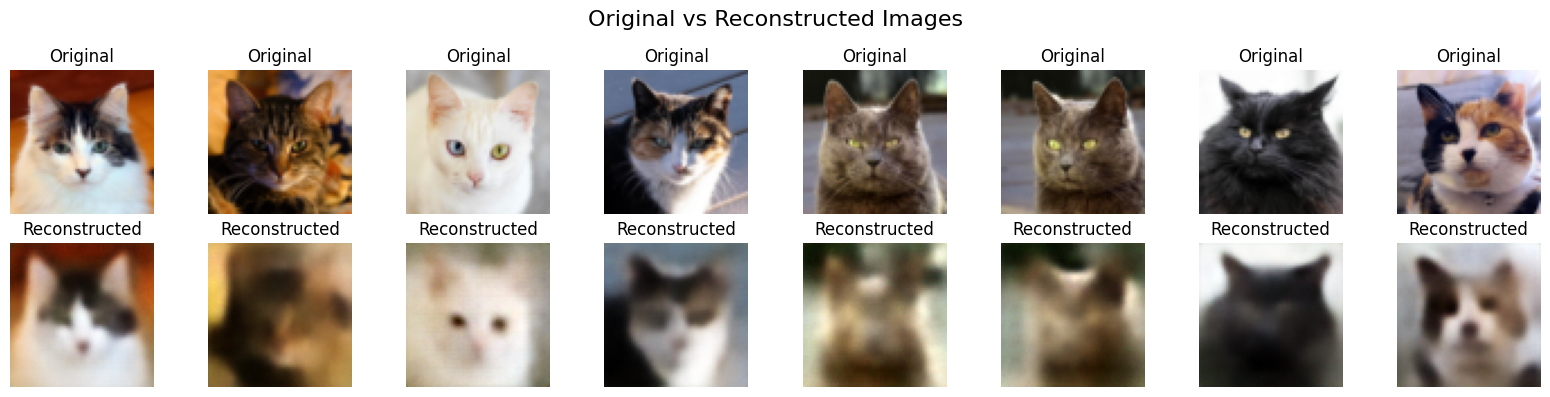

In [17]:
data_iter = iter(val_loader)
images, _ = next(data_iter)
visualize_reconstructions(model, images, device)

#### <font color='red'>2. Model with kl_weight=0.1</font>

In [18]:
# Model training parameters
learning_rate=0.0001
step_size=10
gamma=0.5

kl_weight=0.1

num_epochs=40

name=f"run_kl_wgt_{str(kl_weight)}_ep_{num_epochs}"
project="assignment-5"


latent_dim = 512 # define latent dimension

# Load model
model = ConvVAE(latent_dim=latent_dim).to(device)
# model

model = run_vae_training(
    model, train_loader, val_loader, device, 
    num_epochs=num_epochs, learning_rate=learning_rate,
    step_size=step_size, gamma=gamma,
    kl_weight=kl_weight,
    name=name, project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

Training Name: run_kl_wgt_0.1_ep_40
Total num. of Epochs: 40
Learning Rate: 0.0001
KL Weight used for Loss function: 0.1



  2%|█▍                                                      | 1/40 [00:10<06:33, 10.08s/it]


Epoch 1/40
Learning Rate: 0.000100
Train - Total: 1258.8509, Recon: 1207.1250, KL: 517.2595
Eval  - Total: 759.5104, Recon: 699.9445, KL: 595.6588


  5%|██▊                                                     | 2/40 [00:20<06:22, 10.07s/it]


Epoch 2/40
Learning Rate: 0.000100
Train - Total: 690.0430, Recon: 626.0716, KL: 639.7141
Eval  - Total: 595.4492, Recon: 527.7296, KL: 677.1963


  8%|████▏                                                   | 3/40 [00:30<06:13, 10.10s/it]


Epoch 3/40
Learning Rate: 0.000100
Train - Total: 593.3506, Recon: 524.2317, KL: 691.1892
Eval  - Total: 523.3196, Recon: 453.3228, KL: 699.9680


 10%|█████▌                                                  | 4/40 [00:39<05:55,  9.87s/it]


Epoch 4/40
Learning Rate: 0.000100
Train - Total: 547.3897, Recon: 475.7260, KL: 716.6373
Eval  - Total: 500.2247, Recon: 427.8864, KL: 723.3830


 12%|███████                                                 | 5/40 [00:49<05:44,  9.85s/it]


Epoch 5/40
Learning Rate: 0.000100
Train - Total: 510.5911, Recon: 437.3927, KL: 731.9838
Eval  - Total: 472.7183, Recon: 399.4531, KL: 732.6517


 15%|████████▍                                               | 6/40 [00:59<05:37,  9.94s/it]


Epoch 6/40
Learning Rate: 0.000100
Train - Total: 489.8543, Recon: 415.3288, KL: 745.2544
Eval  - Total: 457.6786, Recon: 381.9500, KL: 757.2861


 18%|█████████▊                                              | 7/40 [01:09<05:25,  9.87s/it]


Epoch 7/40
Learning Rate: 0.000100
Train - Total: 471.1657, Recon: 395.9720, KL: 751.9362
Eval  - Total: 430.5546, Recon: 355.4971, KL: 750.5751


 20%|███████████▏                                            | 8/40 [01:19<05:13,  9.80s/it]


Epoch 8/40
Learning Rate: 0.000100
Train - Total: 457.9232, Recon: 382.3360, KL: 755.8721
Eval  - Total: 432.1422, Recon: 357.2079, KL: 749.3430


 22%|████████████▌                                           | 9/40 [01:29<05:04,  9.83s/it]


Epoch 9/40
Learning Rate: 0.000100
Train - Total: 437.8788, Recon: 361.9577, KL: 759.2111
Eval  - Total: 393.1479, Recon: 317.5808, KL: 755.6708


 25%|█████████████▊                                         | 10/40 [01:38<04:55,  9.85s/it]


Epoch 10/40
Learning Rate: 0.000100
Train - Total: 421.1882, Recon: 345.1799, KL: 760.0831
Eval  - Total: 399.3001, Recon: 323.4146, KL: 758.8551


 28%|███████████████▏                                       | 11/40 [01:48<04:43,  9.78s/it]


Epoch 11/40
Learning Rate: 0.000050
Train - Total: 398.0122, Recon: 322.7866, KL: 752.2553
Eval  - Total: 359.8275, Recon: 285.9381, KL: 738.8946


 30%|████████████████▌                                      | 12/40 [01:58<04:35,  9.84s/it]


Epoch 12/40
Learning Rate: 0.000050
Train - Total: 388.9468, Recon: 314.0380, KL: 749.0879
Eval  - Total: 366.4667, Recon: 292.1240, KL: 743.4263


 32%|█████████████████▉                                     | 13/40 [02:08<04:30, 10.01s/it]


Epoch 13/40
Learning Rate: 0.000050
Train - Total: 383.8655, Recon: 308.7981, KL: 750.6736
Eval  - Total: 350.3410, Recon: 277.0480, KL: 732.9297


 35%|███████████████████▎                                   | 14/40 [02:18<04:18,  9.95s/it]


Epoch 14/40
Learning Rate: 0.000050
Train - Total: 376.7483, Recon: 301.6663, KL: 750.8202
Eval  - Total: 347.2693, Recon: 272.6550, KL: 746.1435


 38%|████████████████████▋                                  | 15/40 [02:28<04:05,  9.81s/it]


Epoch 15/40
Learning Rate: 0.000050
Train - Total: 372.1192, Recon: 296.8351, KL: 752.8406
Eval  - Total: 343.0771, Recon: 268.4776, KL: 745.9951


 40%|██████████████████████                                 | 16/40 [02:37<03:55,  9.80s/it]


Epoch 16/40
Learning Rate: 0.000050
Train - Total: 366.4046, Recon: 290.8514, KL: 755.5321
Eval  - Total: 338.4293, Recon: 265.2701, KL: 731.5916


 42%|███████████████████████▍                               | 17/40 [02:47<03:46,  9.85s/it]


Epoch 17/40
Learning Rate: 0.000050
Train - Total: 362.9802, Recon: 287.2919, KL: 756.8831
Eval  - Total: 338.8288, Recon: 264.5064, KL: 743.2245


 45%|████████████████████████▊                              | 18/40 [02:57<03:34,  9.76s/it]


Epoch 18/40
Learning Rate: 0.000050
Train - Total: 359.5517, Recon: 283.5715, KL: 759.8017
Eval  - Total: 346.7483, Recon: 272.6788, KL: 740.6950


 48%|██████████████████████████▏                            | 19/40 [03:07<03:25,  9.81s/it]


Epoch 19/40
Learning Rate: 0.000050
Train - Total: 354.9841, Recon: 278.8544, KL: 761.2969
Eval  - Total: 331.5640, Recon: 256.4289, KL: 751.3508


 50%|███████████████████████████▌                           | 20/40 [03:17<03:16,  9.81s/it]


Epoch 20/40
Learning Rate: 0.000050
Train - Total: 350.5559, Recon: 274.2439, KL: 763.1201
Eval  - Total: 324.2156, Recon: 248.1927, KL: 760.2297


 52%|████████████████████████████▉                          | 21/40 [03:27<03:06,  9.84s/it]


Epoch 21/40
Learning Rate: 0.000025
Train - Total: 338.4949, Recon: 262.4986, KL: 759.9629
Eval  - Total: 315.1307, Recon: 240.1914, KL: 749.3938


 55%|██████████████████████████████▎                        | 22/40 [03:36<02:54,  9.72s/it]


Epoch 22/40
Learning Rate: 0.000025
Train - Total: 333.9227, Recon: 257.9920, KL: 759.3073
Eval  - Total: 319.1938, Recon: 244.4077, KL: 747.8608


 57%|███████████████████████████████▌                       | 23/40 [03:46<02:44,  9.68s/it]


Epoch 23/40
Learning Rate: 0.000025
Train - Total: 333.3208, Recon: 257.4559, KL: 758.6490
Eval  - Total: 314.7047, Recon: 239.9410, KL: 747.6361


 60%|█████████████████████████████████                      | 24/40 [03:55<02:34,  9.67s/it]


Epoch 24/40
Learning Rate: 0.000025
Train - Total: 331.1596, Recon: 255.1686, KL: 759.9106
Eval  - Total: 313.8351, Recon: 238.8773, KL: 749.5777


 62%|██████████████████████████████████▍                    | 25/40 [04:05<02:25,  9.73s/it]


Epoch 25/40
Learning Rate: 0.000025
Train - Total: 328.2542, Recon: 252.2253, KL: 760.2888
Eval  - Total: 312.0634, Recon: 236.3713, KL: 756.9207


 65%|███████████████████████████████████▊                   | 26/40 [04:15<02:17,  9.83s/it]


Epoch 26/40
Learning Rate: 0.000025
Train - Total: 325.6197, Recon: 249.5762, KL: 760.4342
Eval  - Total: 311.5289, Recon: 236.8738, KL: 746.5513


 68%|█████████████████████████████████████▏                 | 27/40 [04:25<02:08,  9.86s/it]


Epoch 27/40
Learning Rate: 0.000025
Train - Total: 323.6248, Recon: 247.4857, KL: 761.3913
Eval  - Total: 308.7757, Recon: 233.1527, KL: 756.2301


 70%|██████████████████████████████████████▌                | 28/40 [04:35<01:58,  9.89s/it]


Epoch 28/40
Learning Rate: 0.000025
Train - Total: 322.1705, Recon: 245.9413, KL: 762.2922
Eval  - Total: 308.9538, Recon: 234.1879, KL: 747.6597


 72%|███████████████████████████████████████▉               | 29/40 [04:45<01:48,  9.90s/it]


Epoch 29/40
Learning Rate: 0.000025
Train - Total: 320.3418, Recon: 243.9386, KL: 764.0313
Eval  - Total: 309.1062, Recon: 234.3191, KL: 747.8703


 75%|█████████████████████████████████████████▎             | 30/40 [04:55<01:39,  9.94s/it]


Epoch 30/40
Learning Rate: 0.000025
Train - Total: 319.2394, Recon: 242.9021, KL: 763.3730
Eval  - Total: 307.2227, Recon: 232.7384, KL: 744.8430


 78%|██████████████████████████████████████████▋            | 31/40 [05:05<01:29,  9.95s/it]


Epoch 31/40
Learning Rate: 0.000013
Train - Total: 313.0480, Recon: 236.6757, KL: 763.7225
Eval  - Total: 302.4172, Recon: 226.5413, KL: 758.7593


 80%|████████████████████████████████████████████           | 32/40 [05:15<01:19,  9.96s/it]


Epoch 32/40
Learning Rate: 0.000013
Train - Total: 310.4651, Recon: 234.1476, KL: 763.1759
Eval  - Total: 302.4367, Recon: 227.1871, KL: 752.4955


 82%|█████████████████████████████████████████████▍         | 33/40 [05:25<01:09,  9.96s/it]


Epoch 33/40
Learning Rate: 0.000013
Train - Total: 310.0220, Recon: 233.5481, KL: 764.7387
Eval  - Total: 301.5526, Recon: 227.0000, KL: 745.5265


 85%|██████████████████████████████████████████████▊        | 34/40 [05:35<00:59,  9.98s/it]


Epoch 34/40
Learning Rate: 0.000013
Train - Total: 308.7142, Recon: 232.3670, KL: 763.4716
Eval  - Total: 301.5676, Recon: 226.8908, KL: 746.7671


 88%|████████████████████████████████████████████████▏      | 35/40 [05:45<00:49,  9.95s/it]


Epoch 35/40
Learning Rate: 0.000013
Train - Total: 307.0455, Recon: 230.6622, KL: 763.8336
Eval  - Total: 299.2506, Recon: 224.2118, KL: 750.3884


 90%|█████████████████████████████████████████████████▌     | 36/40 [05:55<00:39,  9.98s/it]


Epoch 36/40
Learning Rate: 0.000013
Train - Total: 306.7492, Recon: 230.2960, KL: 764.5318
Eval  - Total: 299.1024, Recon: 223.7927, KL: 753.0970


 92%|██████████████████████████████████████████████████▉    | 37/40 [06:05<00:30, 10.02s/it]


Epoch 37/40
Learning Rate: 0.000013
Train - Total: 305.6497, Recon: 229.2229, KL: 764.2681
Eval  - Total: 299.6752, Recon: 224.6912, KL: 749.8400


 95%|████████████████████████████████████████████████████▎  | 38/40 [06:15<00:20, 10.11s/it]


Epoch 38/40
Learning Rate: 0.000013
Train - Total: 305.0753, Recon: 228.5635, KL: 765.1181
Eval  - Total: 298.6526, Recon: 223.2443, KL: 754.0828


 98%|█████████████████████████████████████████████████████▋ | 39/40 [06:26<00:10, 10.29s/it]


Epoch 39/40
Learning Rate: 0.000013
Train - Total: 303.0291, Recon: 226.5580, KL: 764.7115
Eval  - Total: 298.2225, Recon: 222.6632, KL: 755.5929


100%|███████████████████████████████████████████████████████| 40/40 [06:37<00:00,  9.93s/it]


Epoch 40/40
Learning Rate: 0.000013
Train - Total: 302.3982, Recon: 225.7891, KL: 766.0902
Eval  - Total: 298.0493, Recon: 223.3249, KL: 747.2441


Model saved at: ./saved_models/run_kl_wgt_0.1_ep_40


In [19]:
model = load_model(save_path)
max_samples = min(2000, len(val_loader.dataset))
fid_score = compute_fid_score(model, val_loader, device, max_samples=max_samples)
print(f"FID Score for model {name}: {fid_score}")

/tmp/ipykernel_1733915/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FID Score for model run_kl_wgt_0.1_ep_40: 121.25184631347656


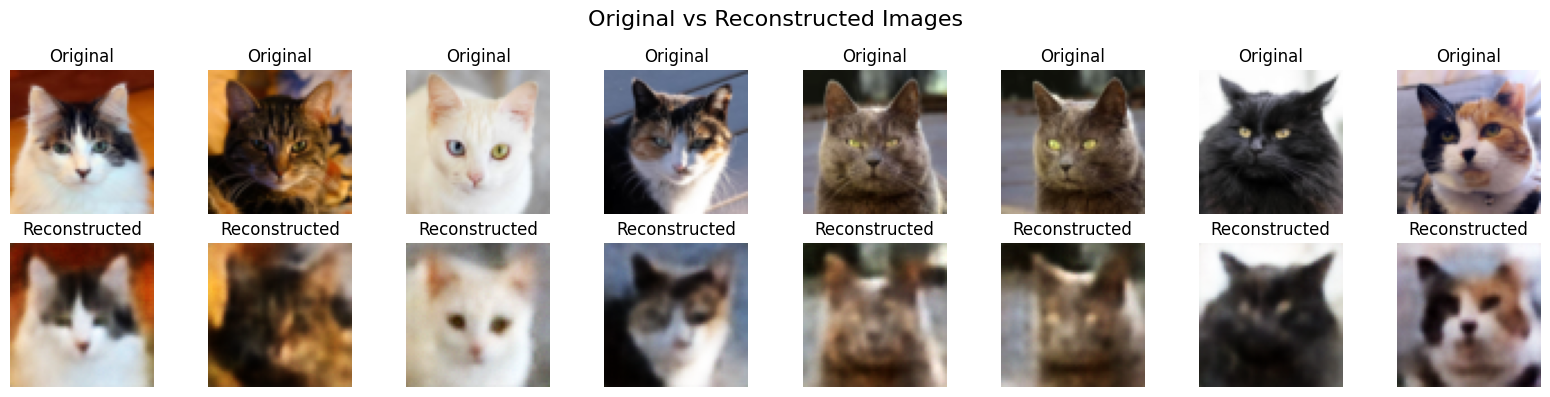

In [20]:
data_iter = iter(val_loader)
images, _ = next(data_iter)
visualize_reconstructions(model, images, device)

#### <font color='red'>3. Model with kl_weight=0.01</font>

In [21]:
# Model training parameters
learning_rate=0.0001
step_size=10
gamma=0.5

kl_weight=0.01

num_epochs=40

name=f"run_kl_wgt_{str(kl_weight)}_ep_{num_epochs}"
project="assignment-5"


latent_dim = 512 # define latent dimension

# Load model
model = ConvVAE(latent_dim=latent_dim).to(device)
# model

model = run_vae_training(
    model, train_loader, val_loader, device, 
    num_epochs=num_epochs, learning_rate=learning_rate,
    step_size=step_size, gamma=gamma,
    kl_weight=kl_weight,
    name=name, project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

Training Name: run_kl_wgt_0.01_ep_40
Total num. of Epochs: 40
Learning Rate: 0.0001
KL Weight used for Loss function: 0.01



  2%|█▍                                                      | 1/40 [00:10<06:55, 10.64s/it]


Epoch 1/40
Learning Rate: 0.000100
Train - Total: 1213.6543, Recon: 1198.3028, KL: 1535.1439
Eval  - Total: 693.2786, Recon: 679.2497, KL: 1402.8917


  5%|██▊                                                     | 2/40 [00:21<06:47, 10.72s/it]


Epoch 2/40
Learning Rate: 0.000100
Train - Total: 600.2389, Recon: 585.3461, KL: 1489.2825
Eval  - Total: 505.6931, Recon: 490.2629, KL: 1543.0147


  8%|████▏                                                   | 3/40 [00:31<06:32, 10.62s/it]


Epoch 3/40
Learning Rate: 0.000100
Train - Total: 497.2435, Recon: 481.4563, KL: 1578.7202
Eval  - Total: 458.2141, Recon: 442.1743, KL: 1603.9757


 10%|█████▌                                                  | 4/40 [00:42<06:19, 10.55s/it]


Epoch 4/40
Learning Rate: 0.000100
Train - Total: 447.9578, Recon: 431.5598, KL: 1639.8038
Eval  - Total: 425.6049, Recon: 408.2856, KL: 1731.9317


 12%|███████                                                 | 5/40 [00:52<06:08, 10.53s/it]


Epoch 5/40
Learning Rate: 0.000100
Train - Total: 408.6603, Recon: 391.6784, KL: 1698.1912
Eval  - Total: 371.3756, Recon: 353.8571, KL: 1751.8481


 15%|████████▍                                               | 6/40 [01:03<05:59, 10.59s/it]


Epoch 6/40
Learning Rate: 0.000100
Train - Total: 382.5208, Recon: 365.1862, KL: 1733.4668
Eval  - Total: 355.0986, Recon: 337.6106, KL: 1748.8032


 18%|█████████▊                                              | 7/40 [01:14<05:48, 10.56s/it]


Epoch 7/40
Learning Rate: 0.000100
Train - Total: 361.1658, Recon: 343.4871, KL: 1767.8698
Eval  - Total: 341.2126, Recon: 323.7548, KL: 1745.7734


 20%|███████████▏                                            | 8/40 [01:24<05:36, 10.52s/it]


Epoch 8/40
Learning Rate: 0.000100
Train - Total: 338.8083, Recon: 320.9808, KL: 1782.7479
Eval  - Total: 324.9578, Recon: 307.3096, KL: 1764.8212


 22%|████████████▌                                           | 9/40 [01:35<05:28, 10.61s/it]


Epoch 9/40
Learning Rate: 0.000100
Train - Total: 325.4405, Recon: 307.5360, KL: 1790.4481
Eval  - Total: 321.0055, Recon: 302.7354, KL: 1827.0110


 25%|█████████████▊                                         | 10/40 [01:45<05:15, 10.51s/it]


Epoch 10/40
Learning Rate: 0.000100
Train - Total: 314.2342, Recon: 296.1838, KL: 1805.0424
Eval  - Total: 309.5330, Recon: 291.6621, KL: 1787.0860


 28%|███████████████▏                                       | 11/40 [01:56<05:05, 10.55s/it]


Epoch 11/40
Learning Rate: 0.000050
Train - Total: 292.7871, Recon: 274.7813, KL: 1800.5797
Eval  - Total: 275.7605, Recon: 258.1382, KL: 1762.2246


 30%|████████████████▌                                      | 12/40 [02:06<04:55, 10.56s/it]


Epoch 12/40
Learning Rate: 0.000050
Train - Total: 284.9790, Recon: 267.3086, KL: 1767.0405
Eval  - Total: 278.4642, Recon: 260.8350, KL: 1762.9216


 32%|█████████████████▉                                     | 13/40 [02:17<04:45, 10.59s/it]


Epoch 13/40
Learning Rate: 0.000050
Train - Total: 280.9578, Recon: 263.5057, KL: 1745.2022
Eval  - Total: 268.2023, Recon: 251.1344, KL: 1706.7872


 35%|███████████████████▎                                   | 14/40 [02:28<04:35, 10.60s/it]


Epoch 14/40
Learning Rate: 0.000050
Train - Total: 276.0926, Recon: 258.7365, KL: 1735.6140
Eval  - Total: 271.3072, Recon: 254.2295, KL: 1707.7766


 38%|████████████████████▋                                  | 15/40 [02:38<04:24, 10.56s/it]


Epoch 15/40
Learning Rate: 0.000050
Train - Total: 271.9901, Recon: 254.6906, KL: 1729.9449
Eval  - Total: 272.3507, Recon: 255.3908, KL: 1695.9941


 40%|██████████████████████                                 | 16/40 [02:49<04:13, 10.56s/it]


Epoch 16/40
Learning Rate: 0.000050
Train - Total: 264.8941, Recon: 247.6584, KL: 1723.5678
Eval  - Total: 260.2751, Recon: 243.1631, KL: 1711.1997


 42%|███████████████████████▍                               | 17/40 [02:59<04:02, 10.54s/it]


Epoch 17/40
Learning Rate: 0.000050
Train - Total: 259.7062, Recon: 242.5451, KL: 1716.1149
Eval  - Total: 251.6068, Recon: 234.5969, KL: 1700.9903


 45%|████████████████████████▊                              | 18/40 [03:10<03:52, 10.56s/it]


Epoch 18/40
Learning Rate: 0.000050
Train - Total: 257.7001, Recon: 240.5690, KL: 1713.1026
Eval  - Total: 252.2843, Recon: 235.3865, KL: 1689.7864


 48%|██████████████████████████▏                            | 19/40 [03:20<03:42, 10.62s/it]


Epoch 19/40
Learning Rate: 0.000050
Train - Total: 251.7828, Recon: 234.6436, KL: 1713.9163
Eval  - Total: 247.0110, Recon: 229.9705, KL: 1704.0496


 50%|███████████████████████████▌                           | 20/40 [03:31<03:33, 10.65s/it]


Epoch 20/40
Learning Rate: 0.000050
Train - Total: 248.5753, Recon: 231.5148, KL: 1706.0586
Eval  - Total: 254.8045, Recon: 237.6746, KL: 1712.9904


 52%|████████████████████████████▉                          | 21/40 [03:42<03:22, 10.68s/it]


Epoch 21/40
Learning Rate: 0.000025
Train - Total: 237.9383, Recon: 220.9352, KL: 1700.3069
Eval  - Total: 232.3670, Recon: 215.3665, KL: 1700.0533


 55%|██████████████████████████████▎                        | 22/40 [03:53<03:12, 10.68s/it]


Epoch 22/40
Learning Rate: 0.000025
Train - Total: 235.0777, Recon: 218.1824, KL: 1689.5309
Eval  - Total: 231.7440, Recon: 215.1705, KL: 1657.3544


 57%|███████████████████████████████▌                       | 23/40 [04:03<02:59, 10.53s/it]


Epoch 23/40
Learning Rate: 0.000025
Train - Total: 232.5116, Recon: 215.7216, KL: 1678.9994
Eval  - Total: 230.3060, Recon: 213.8762, KL: 1642.9784


 60%|█████████████████████████████████                      | 24/40 [04:13<02:46, 10.39s/it]


Epoch 24/40
Learning Rate: 0.000025
Train - Total: 230.2443, Recon: 213.5336, KL: 1671.0711
Eval  - Total: 230.0724, Recon: 213.4669, KL: 1660.5493


 62%|██████████████████████████████████▍                    | 25/40 [04:24<02:37, 10.47s/it]


Epoch 25/40
Learning Rate: 0.000025
Train - Total: 229.6478, Recon: 212.9877, KL: 1666.0081
Eval  - Total: 227.2112, Recon: 210.4786, KL: 1673.2642


 65%|███████████████████████████████████▊                   | 26/40 [04:34<02:27, 10.52s/it]


Epoch 26/40
Learning Rate: 0.000025
Train - Total: 227.5756, Recon: 210.9738, KL: 1660.1780
Eval  - Total: 223.9981, Recon: 207.7767, KL: 1622.1419


 68%|█████████████████████████████████████▏                 | 27/40 [04:45<02:16, 10.53s/it]


Epoch 27/40
Learning Rate: 0.000025
Train - Total: 223.9713, Recon: 207.4226, KL: 1654.8714
Eval  - Total: 223.4167, Recon: 207.1197, KL: 1629.7055


 70%|██████████████████████████████████████▌                | 28/40 [04:55<02:05, 10.50s/it]


Epoch 28/40
Learning Rate: 0.000025
Train - Total: 222.9008, Recon: 206.4005, KL: 1650.0323
Eval  - Total: 226.0009, Recon: 209.8082, KL: 1619.2659


 72%|███████████████████████████████████████▉               | 29/40 [05:05<01:53, 10.35s/it]


Epoch 29/40
Learning Rate: 0.000025
Train - Total: 220.5929, Recon: 204.1453, KL: 1644.7601
Eval  - Total: 222.1562, Recon: 205.8673, KL: 1628.8881


 75%|█████████████████████████████████████████▎             | 30/40 [05:15<01:42, 10.26s/it]


Epoch 30/40
Learning Rate: 0.000025
Train - Total: 219.5484, Recon: 203.1268, KL: 1642.1608
Eval  - Total: 221.4825, Recon: 205.1464, KL: 1633.6063


 78%|██████████████████████████████████████████▋            | 31/40 [05:26<01:33, 10.34s/it]


Epoch 31/40
Learning Rate: 0.000013
Train - Total: 215.1189, Recon: 198.7099, KL: 1640.8962
Eval  - Total: 215.0542, Recon: 198.8625, KL: 1619.1789


 80%|████████████████████████████████████████████           | 32/40 [05:36<01:22, 10.30s/it]


Epoch 32/40
Learning Rate: 0.000013
Train - Total: 212.5831, Recon: 196.2135, KL: 1636.9676
Eval  - Total: 214.6767, Recon: 198.2998, KL: 1637.6902


 82%|█████████████████████████████████████████████▍         | 33/40 [05:46<01:11, 10.27s/it]


Epoch 33/40
Learning Rate: 0.000013
Train - Total: 211.2908, Recon: 194.9720, KL: 1631.8797
Eval  - Total: 214.5274, Recon: 198.4993, KL: 1602.8141


 85%|██████████████████████████████████████████████▊        | 34/40 [05:57<01:02, 10.39s/it]


Epoch 34/40
Learning Rate: 0.000013
Train - Total: 210.3361, Recon: 194.0347, KL: 1630.1307
Eval  - Total: 215.0036, Recon: 199.0210, KL: 1598.2658


 88%|████████████████████████████████████████████████▏      | 35/40 [06:07<00:52, 10.45s/it]


Epoch 35/40
Learning Rate: 0.000013
Train - Total: 209.5770, Recon: 193.3296, KL: 1624.7373
Eval  - Total: 212.5056, Recon: 196.4031, KL: 1610.2577


 90%|█████████████████████████████████████████████████▌     | 36/40 [06:18<00:41, 10.43s/it]


Epoch 36/40
Learning Rate: 0.000013
Train - Total: 208.5322, Recon: 192.2891, KL: 1624.3078
Eval  - Total: 212.0321, Recon: 196.0388, KL: 1599.3291


 92%|██████████████████████████████████████████████████▉    | 37/40 [06:28<00:31, 10.52s/it]


Epoch 37/40
Learning Rate: 0.000013
Train - Total: 207.8017, Recon: 191.6022, KL: 1619.9594
Eval  - Total: 210.4221, Recon: 194.4091, KL: 1601.3052


 95%|████████████████████████████████████████████████████▎  | 38/40 [06:39<00:21, 10.53s/it]


Epoch 38/40
Learning Rate: 0.000013
Train - Total: 206.3183, Recon: 190.1502, KL: 1616.8101
Eval  - Total: 211.4306, Recon: 195.1561, KL: 1627.4525


 98%|█████████████████████████████████████████████████████▋ | 39/40 [06:50<00:10, 10.59s/it]


Epoch 39/40
Learning Rate: 0.000013
Train - Total: 205.9723, Recon: 189.8159, KL: 1615.6447
Eval  - Total: 210.2877, Recon: 194.2403, KL: 1604.7457


100%|███████████████████████████████████████████████████████| 40/40 [07:00<00:00, 10.52s/it]


Epoch 40/40
Learning Rate: 0.000013
Train - Total: 204.3881, Recon: 188.2723, KL: 1611.5792
Eval  - Total: 210.2212, Recon: 194.2616, KL: 1595.9584


Model saved at: ./saved_models/run_kl_wgt_0.01_ep_40


In [22]:
model = load_model(save_path)
max_samples = min(2000, len(val_loader.dataset))
fid_score = compute_fid_score(model, val_loader, device, max_samples=max_samples)
print(f"FID Score for model {name}: {fid_score}")

/tmp/ipykernel_1733915/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FID Score for model run_kl_wgt_0.01_ep_40: 116.30049133300781


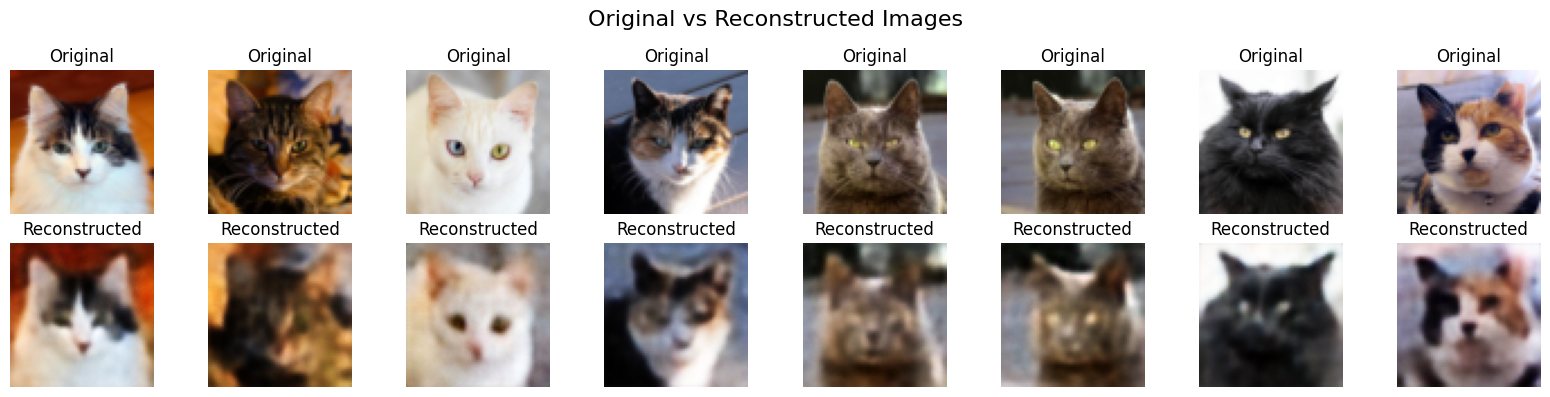

In [23]:
data_iter = iter(val_loader)
images, _ = next(data_iter)
visualize_reconstructions(model, images, device)

#### <font color='red'>4. Model with kl_weight=0.001</font>

In [24]:
# Model training parameters
learning_rate=0.0001
step_size=10
gamma=0.5

kl_weight=0.001

num_epochs=40

name=f"run_kl_wgt_{str(kl_weight)}_ep_{num_epochs}"
project="assignment-5"


latent_dim = 512 # define latent dimension

# Load model
model = ConvVAE(latent_dim=latent_dim).to(device)
# model

model = run_vae_training(
    model, train_loader, val_loader, device, 
    num_epochs=num_epochs, learning_rate=learning_rate,
    step_size=step_size, gamma=gamma,
    kl_weight=kl_weight,
    name=name, project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

Training Name: run_kl_wgt_0.001_ep_40
Total num. of Epochs: 40
Learning Rate: 0.0001
KL Weight used for Loss function: 0.001



  2%|█▍                                                      | 1/40 [00:10<06:35, 10.13s/it]


Epoch 1/40
Learning Rate: 0.000100
Train - Total: 8115.5196, Recon: 1376.7011, KL: 6738818.2610
Eval  - Total: 887.5048, Recon: 885.8226, KL: 1682.2190


  5%|██▊                                                     | 2/40 [00:20<06:27, 10.20s/it]


Epoch 2/40
Learning Rate: 0.000100
Train - Total: 801.7558, Recon: 799.9778, KL: 1777.9922
Eval  - Total: 700.7922, Recon: 698.9099, KL: 1882.3268


  8%|████▏                                                   | 3/40 [00:30<06:14, 10.13s/it]


Epoch 3/40
Learning Rate: 0.000100
Train - Total: 678.5595, Recon: 676.6249, KL: 1934.6184
Eval  - Total: 614.0416, Recon: 612.0493, KL: 1992.3010


 10%|█████▌                                                  | 4/40 [00:40<06:06, 10.18s/it]


Epoch 4/40
Learning Rate: 0.000100
Train - Total: 608.9004, Recon: 606.8284, KL: 2071.9882
Eval  - Total: 554.8639, Recon: 552.7358, KL: 2128.0999


 12%|███████                                                 | 5/40 [00:51<06:01, 10.32s/it]


Epoch 5/40
Learning Rate: 0.000100
Train - Total: 562.2786, Recon: 560.1247, KL: 2153.9194
Eval  - Total: 516.7047, Recon: 514.5925, KL: 2112.2260


 15%|████████▍                                               | 6/40 [01:01<05:47, 10.23s/it]


Epoch 6/40
Learning Rate: 0.000100
Train - Total: 519.9675, Recon: 517.7671, KL: 2200.4519
Eval  - Total: 515.8651, Recon: 513.7017, KL: 2163.3537


 18%|█████████▊                                              | 7/40 [01:11<05:41, 10.34s/it]


Epoch 7/40
Learning Rate: 0.000100
Train - Total: 487.3518, Recon: 485.1121, KL: 2239.7695
Eval  - Total: 465.0147, Recon: 462.7682, KL: 2246.4318


 20%|███████████▏                                            | 8/40 [01:22<05:29, 10.29s/it]


Epoch 8/40
Learning Rate: 0.000100
Train - Total: 461.5126, Recon: 459.2229, KL: 2289.6960
Eval  - Total: 435.8317, Recon: 433.5158, KL: 2315.8536


 22%|████████████▌                                           | 9/40 [01:32<05:24, 10.46s/it]


Epoch 9/40
Learning Rate: 0.000100
Train - Total: 431.7985, Recon: 429.4377, KL: 2360.8163
Eval  - Total: 423.0303, Recon: 420.6523, KL: 2378.0409


 25%|█████████████▊                                         | 10/40 [01:43<05:11, 10.39s/it]


Epoch 10/40
Learning Rate: 0.000100
Train - Total: 407.6339, Recon: 405.2209, KL: 2412.9914
Eval  - Total: 403.8779, Recon: 401.4821, KL: 2395.8419


 28%|███████████████▏                                       | 11/40 [01:53<04:59, 10.32s/it]


Epoch 11/40
Learning Rate: 0.000050
Train - Total: 379.6081, Recon: 377.1573, KL: 2450.7653
Eval  - Total: 374.8124, Recon: 372.3884, KL: 2423.9949


 30%|████████████████▌                                      | 12/40 [02:03<04:48, 10.32s/it]


Epoch 12/40
Learning Rate: 0.000050
Train - Total: 367.1186, Recon: 364.6538, KL: 2464.7560
Eval  - Total: 370.4675, Recon: 368.0395, KL: 2428.0700


 32%|█████████████████▉                                     | 13/40 [02:13<04:37, 10.26s/it]


Epoch 13/40
Learning Rate: 0.000050
Train - Total: 358.8763, Recon: 356.3819, KL: 2494.3559
Eval  - Total: 368.3275, Recon: 365.8706, KL: 2456.9379


 35%|███████████████████▎                                   | 14/40 [02:23<04:25, 10.21s/it]


Epoch 14/40
Learning Rate: 0.000050
Train - Total: 348.7713, Recon: 346.2480, KL: 2523.2793
Eval  - Total: 356.4887, Recon: 353.9915, KL: 2497.1731


 38%|████████████████████▋                                  | 15/40 [02:34<04:17, 10.29s/it]


Epoch 15/40
Learning Rate: 0.000050
Train - Total: 340.7794, Recon: 338.2313, KL: 2548.1450
Eval  - Total: 359.7280, Recon: 357.1794, KL: 2548.6148


 40%|██████████████████████                                 | 16/40 [02:44<04:07, 10.31s/it]


Epoch 16/40
Learning Rate: 0.000050
Train - Total: 333.4814, Recon: 330.9046, KL: 2576.8003
Eval  - Total: 346.2883, Recon: 343.7180, KL: 2570.3409


 42%|███████████████████████▍                               | 17/40 [02:54<03:51, 10.07s/it]


Epoch 17/40
Learning Rate: 0.000050
Train - Total: 323.5186, Recon: 320.9163, KL: 2602.2768
Eval  - Total: 358.9328, Recon: 356.3365, KL: 2596.3686


 45%|████████████████████████▊                              | 18/40 [03:03<03:37,  9.90s/it]


Epoch 18/40
Learning Rate: 0.000050
Train - Total: 316.4214, Recon: 313.7929, KL: 2628.4532
Eval  - Total: 331.3238, Recon: 328.6976, KL: 2626.1188


 48%|██████████████████████████▏                            | 19/40 [03:13<03:25,  9.77s/it]


Epoch 19/40
Learning Rate: 0.000050
Train - Total: 308.9981, Recon: 306.3358, KL: 2662.3021
Eval  - Total: 325.9740, Recon: 323.3392, KL: 2634.8142


 50%|███████████████████████████▌                           | 20/40 [03:22<03:15,  9.77s/it]


Epoch 20/40
Learning Rate: 0.000050
Train - Total: 301.4173, Recon: 298.7299, KL: 2687.3286
Eval  - Total: 320.8776, Recon: 318.2057, KL: 2671.9206


 52%|████████████████████████████▉                          | 21/40 [03:32<03:06,  9.83s/it]


Epoch 21/40
Learning Rate: 0.000025
Train - Total: 289.1662, Recon: 286.4592, KL: 2707.0216
Eval  - Total: 317.3930, Recon: 314.7008, KL: 2692.2406


 55%|██████████████████████████████▎                        | 22/40 [03:42<02:55,  9.74s/it]


Epoch 22/40
Learning Rate: 0.000025
Train - Total: 284.8857, Recon: 282.1594, KL: 2726.2648
Eval  - Total: 320.6234, Recon: 317.9496, KL: 2673.7856


 57%|███████████████████████████████▌                       | 23/40 [03:51<02:44,  9.67s/it]


Epoch 23/40
Learning Rate: 0.000025
Train - Total: 281.1507, Recon: 278.4158, KL: 2734.8328
Eval  - Total: 318.7809, Recon: 316.0366, KL: 2744.2218


 60%|█████████████████████████████████                      | 24/40 [04:01<02:34,  9.63s/it]


Epoch 24/40
Learning Rate: 0.000025
Train - Total: 276.9799, Recon: 274.2316, KL: 2748.3173
Eval  - Total: 309.2136, Recon: 306.4733, KL: 2740.2987


 62%|██████████████████████████████████▍                    | 25/40 [04:11<02:26,  9.78s/it]


Epoch 25/40
Learning Rate: 0.000025
Train - Total: 275.4271, Recon: 272.6663, KL: 2760.8105
Eval  - Total: 307.6952, Recon: 304.9175, KL: 2777.6993


 65%|███████████████████████████████████▊                   | 26/40 [04:21<02:17,  9.85s/it]


Epoch 26/40
Learning Rate: 0.000025
Train - Total: 271.9450, Recon: 269.1683, KL: 2776.6858
Eval  - Total: 317.2319, Recon: 314.4617, KL: 2770.2197


 68%|█████████████████████████████████████▏                 | 27/40 [04:31<02:08,  9.89s/it]


Epoch 27/40
Learning Rate: 0.000025
Train - Total: 269.9243, Recon: 267.1319, KL: 2792.3824
Eval  - Total: 303.0000, Recon: 300.2417, KL: 2758.2233


 70%|██████████████████████████████████████▌                | 28/40 [04:41<01:59,  9.93s/it]


Epoch 28/40
Learning Rate: 0.000025
Train - Total: 263.8616, Recon: 261.0550, KL: 2806.5657
Eval  - Total: 301.6818, Recon: 298.9239, KL: 2757.9355


 72%|███████████████████████████████████████▉               | 29/40 [04:51<01:49,  9.94s/it]


Epoch 29/40
Learning Rate: 0.000025
Train - Total: 262.3808, Recon: 259.5630, KL: 2817.8269
Eval  - Total: 308.0020, Recon: 305.1771, KL: 2824.8790


 75%|█████████████████████████████████████████▎             | 30/40 [05:01<01:39,  9.97s/it]


Epoch 30/40
Learning Rate: 0.000025
Train - Total: 260.7600, Recon: 257.9285, KL: 2831.5032
Eval  - Total: 299.2082, Recon: 296.4066, KL: 2801.6037


 78%|██████████████████████████████████████████▋            | 31/40 [05:11<01:29,  9.96s/it]


Epoch 31/40
Learning Rate: 0.000013
Train - Total: 253.1672, Recon: 250.3217, KL: 2845.5464
Eval  - Total: 294.4282, Recon: 291.6039, KL: 2824.3851


 80%|████████████████████████████████████████████           | 32/40 [05:21<01:19,  9.99s/it]


Epoch 32/40
Learning Rate: 0.000013
Train - Total: 250.4617, Recon: 247.6094, KL: 2852.3238
Eval  - Total: 294.6895, Recon: 291.8797, KL: 2809.7397


 82%|█████████████████████████████████████████████▍         | 33/40 [05:31<01:10, 10.00s/it]


Epoch 33/40
Learning Rate: 0.000013
Train - Total: 248.6031, Recon: 245.7437, KL: 2859.3205
Eval  - Total: 294.4477, Recon: 291.6411, KL: 2806.5869


 85%|██████████████████████████████████████████████▊        | 34/40 [05:41<00:59, 10.00s/it]


Epoch 34/40
Learning Rate: 0.000013
Train - Total: 247.8652, Recon: 245.0006, KL: 2864.6132
Eval  - Total: 292.3600, Recon: 289.5366, KL: 2823.4472


 88%|████████████████████████████████████████████████▏      | 35/40 [05:51<00:50, 10.01s/it]


Epoch 35/40
Learning Rate: 0.000013
Train - Total: 245.6670, Recon: 242.7963, KL: 2870.6870
Eval  - Total: 291.2758, Recon: 288.4171, KL: 2858.7256


 90%|█████████████████████████████████████████████████▌     | 36/40 [06:01<00:40, 10.02s/it]


Epoch 36/40
Learning Rate: 0.000013
Train - Total: 243.7904, Recon: 240.9111, KL: 2879.3032
Eval  - Total: 291.2523, Recon: 288.4004, KL: 2851.9554


 92%|██████████████████████████████████████████████████▉    | 37/40 [06:11<00:30, 10.01s/it]


Epoch 37/40
Learning Rate: 0.000013
Train - Total: 242.9631, Recon: 240.0762, KL: 2886.8379
Eval  - Total: 291.4418, Recon: 288.5980, KL: 2843.7273


 95%|████████████████████████████████████████████████████▎  | 38/40 [06:21<00:20, 10.04s/it]


Epoch 38/40
Learning Rate: 0.000013
Train - Total: 242.2854, Recon: 239.3921, KL: 2893.3197
Eval  - Total: 289.4406, Recon: 286.5851, KL: 2855.4763


 98%|█████████████████████████████████████████████████████▋ | 39/40 [06:31<00:10, 10.05s/it]


Epoch 39/40
Learning Rate: 0.000013
Train - Total: 239.1270, Recon: 236.2244, KL: 2902.5618
Eval  - Total: 287.8492, Recon: 284.9772, KL: 2872.0005


100%|███████████████████████████████████████████████████████| 40/40 [06:41<00:00, 10.04s/it]


Epoch 40/40
Learning Rate: 0.000013
Train - Total: 238.1709, Recon: 235.2643, KL: 2906.6161
Eval  - Total: 286.8282, Recon: 283.9650, KL: 2863.2183


Model saved at: ./saved_models/run_kl_wgt_0.001_ep_40


In [25]:
model = load_model(save_path)
max_samples = min(2000, len(val_loader.dataset))
fid_score = compute_fid_score(model, val_loader, device, max_samples=max_samples)
print(f"FID Score for model {name}: {fid_score}")

/tmp/ipykernel_1733915/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FID Score for model run_kl_wgt_0.001_ep_40: 127.32476806640625


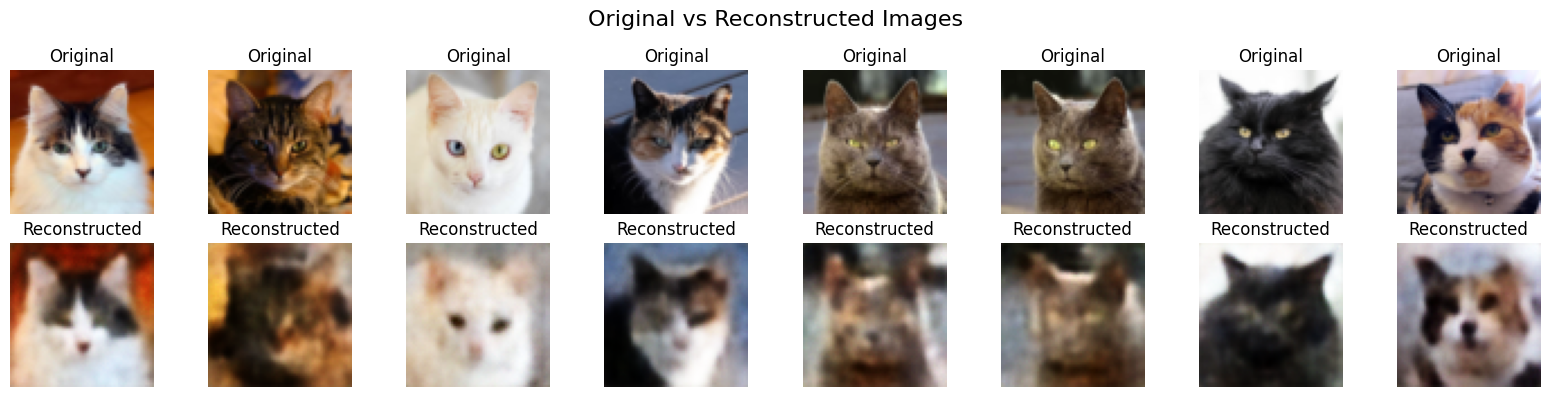

In [26]:
data_iter = iter(val_loader)
images, _ = next(data_iter)
visualize_reconstructions(model, images, device)

#### <font color='red'>5. Model with kl_weight=0.0001</font>

In [27]:
# Model training parameters
learning_rate=0.0001
step_size=10
gamma=0.5

kl_weight=1.5

num_epochs=40

name=f"run_kl_wgt_{str(kl_weight)}_ep_{num_epochs}"
project="assignment-5"


latent_dim = 512 # define latent dimension

# Load model
model = ConvVAE(latent_dim=latent_dim).to(device)
# model

model = run_vae_training(
    model, train_loader, val_loader, device, 
    num_epochs=num_epochs, learning_rate=learning_rate,
    step_size=step_size, gamma=gamma,
    kl_weight=kl_weight,
    name=name, project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

Training Name: run_kl_wgt_1.5_ep_40
Total num. of Epochs: 40
Learning Rate: 0.0001
KL Weight used for Loss function: 1.5



  2%|█▍                                                      | 1/40 [00:21<14:07, 21.73s/it]


Epoch 1/40
Learning Rate: 0.000100
Train - Total: 1592.1220, Recon: 1416.3500, KL: 117.1813
Eval  - Total: 1643.0205, Recon: 1450.1918, KL: 128.5525


  5%|██▊                                                     | 2/40 [00:32<09:32, 15.08s/it]


Epoch 2/40
Learning Rate: 0.000100
Train - Total: 1170.4111, Recon: 973.4448, KL: 131.3109
Eval  - Total: 1186.9340, Recon: 981.4648, KL: 136.9795


  8%|████▏                                                   | 3/40 [00:42<08:02, 13.04s/it]


Epoch 3/40
Learning Rate: 0.000100
Train - Total: 1060.9279, Recon: 849.1793, KL: 141.1658
Eval  - Total: 1025.8007, Recon: 834.1202, KL: 127.7870


 10%|█████▌                                                  | 4/40 [00:53<07:22, 12.28s/it]


Epoch 4/40
Learning Rate: 0.000100
Train - Total: 994.5877, Recon: 781.7380, KL: 141.8998
Eval  - Total: 926.4166, Recon: 725.9608, KL: 133.6372


 12%|███████                                                 | 5/40 [01:04<06:52, 11.79s/it]


Epoch 5/40
Learning Rate: 0.000100
Train - Total: 946.5393, Recon: 736.8359, KL: 139.8023
Eval  - Total: 852.9605, Recon: 649.4820, KL: 135.6524


 15%|████████▍                                               | 6/40 [01:15<06:28, 11.43s/it]


Epoch 6/40
Learning Rate: 0.000100
Train - Total: 913.3265, Recon: 707.9790, KL: 136.8984
Eval  - Total: 812.6823, Recon: 610.5463, KL: 134.7573


 18%|█████████▊                                              | 7/40 [01:26<06:14, 11.34s/it]


Epoch 7/40
Learning Rate: 0.000100
Train - Total: 882.3863, Recon: 681.6422, KL: 133.8294
Eval  - Total: 803.8169, Recon: 603.0580, KL: 133.8393


 20%|███████████▏                                            | 8/40 [01:37<05:56, 11.14s/it]


Epoch 8/40
Learning Rate: 0.000100
Train - Total: 857.8292, Recon: 660.7716, KL: 131.3718
Eval  - Total: 793.9399, Recon: 609.1895, KL: 123.1669


 22%|████████████▌                                           | 9/40 [01:48<05:48, 11.23s/it]


Epoch 9/40
Learning Rate: 0.000100
Train - Total: 841.0260, Recon: 645.9652, KL: 130.0406
Eval  - Total: 768.0902, Recon: 576.3167, KL: 127.8490


 25%|█████████████▊                                         | 10/40 [02:00<05:42, 11.43s/it]


Epoch 10/40
Learning Rate: 0.000100
Train - Total: 826.5798, Recon: 633.1705, KL: 128.9395
Eval  - Total: 752.0478, Recon: 566.8227, KL: 123.4834


 28%|███████████████▏                                       | 11/40 [02:11<05:29, 11.37s/it]


Epoch 11/40
Learning Rate: 0.000050
Train - Total: 793.6565, Recon: 606.2691, KL: 124.9249
Eval  - Total: 740.6782, Recon: 563.5862, KL: 118.0614


 30%|████████████████▌                                      | 12/40 [02:24<05:26, 11.67s/it]


Epoch 12/40
Learning Rate: 0.000050
Train - Total: 784.6284, Recon: 598.3583, KL: 124.1800
Eval  - Total: 720.0477, Recon: 539.0664, KL: 120.6542


 32%|█████████████████▉                                     | 13/40 [02:35<05:13, 11.60s/it]


Epoch 13/40
Learning Rate: 0.000050
Train - Total: 779.0885, Recon: 592.5303, KL: 124.3722
Eval  - Total: 731.8217, Recon: 552.0348, KL: 119.8579


 35%|███████████████████▎                                   | 14/40 [02:47<05:04, 11.70s/it]


Epoch 14/40
Learning Rate: 0.000050
Train - Total: 773.6781, Recon: 586.8358, KL: 124.5616
Eval  - Total: 734.2290, Recon: 547.7683, KL: 124.3071


 38%|████████████████████▋                                  | 15/40 [02:59<04:52, 11.69s/it]


Epoch 15/40
Learning Rate: 0.000050
Train - Total: 768.4683, Recon: 582.0229, KL: 124.2969
Eval  - Total: 699.0080, Recon: 516.2500, KL: 121.8386


 40%|██████████████████████                                 | 16/40 [03:10<04:38, 11.62s/it]


Epoch 16/40
Learning Rate: 0.000050
Train - Total: 761.6588, Recon: 574.9509, KL: 124.4719
Eval  - Total: 707.7046, Recon: 528.3153, KL: 119.5928


 42%|███████████████████████▍                               | 17/40 [03:22<04:26, 11.60s/it]


Epoch 17/40
Learning Rate: 0.000050
Train - Total: 758.5608, Recon: 571.6255, KL: 124.6235
Eval  - Total: 707.2524, Recon: 531.0603, KL: 117.4614


 45%|████████████████████████▊                              | 18/40 [03:32<04:06, 11.20s/it]


Epoch 18/40
Learning Rate: 0.000050
Train - Total: 752.4258, Recon: 565.2624, KL: 124.7756
Eval  - Total: 717.0768, Recon: 539.2047, KL: 118.5814


 48%|██████████████████████████▏                            | 19/40 [03:44<03:57, 11.29s/it]


Epoch 19/40
Learning Rate: 0.000050
Train - Total: 745.4290, Recon: 557.2302, KL: 125.4658
Eval  - Total: 745.5558, Recon: 550.8660, KL: 129.7932


 50%|███████████████████████████▌                           | 20/40 [03:54<03:42, 11.15s/it]


Epoch 20/40
Learning Rate: 0.000050
Train - Total: 739.2721, Recon: 551.0792, KL: 125.4619
Eval  - Total: 750.9867, Recon: 570.8735, KL: 120.0755


 52%|████████████████████████████▉                          | 21/40 [04:05<03:26, 10.85s/it]


Epoch 21/40
Learning Rate: 0.000025
Train - Total: 727.8790, Recon: 541.1377, KL: 124.4942
Eval  - Total: 716.3787, Recon: 537.3449, KL: 119.3558


 55%|██████████████████████████████▎                        | 22/40 [04:15<03:14, 10.82s/it]


Epoch 22/40
Learning Rate: 0.000025
Train - Total: 722.7244, Recon: 535.9727, KL: 124.5011
Eval  - Total: 716.0070, Recon: 537.5197, KL: 118.9916


 57%|███████████████████████████████▌                       | 23/40 [04:26<03:01, 10.67s/it]


Epoch 23/40
Learning Rate: 0.000025
Train - Total: 720.7783, Recon: 533.9067, KL: 124.5810
Eval  - Total: 691.0029, Recon: 509.0283, KL: 121.3164


 60%|█████████████████████████████████                      | 24/40 [04:36<02:49, 10.61s/it]


Epoch 24/40
Learning Rate: 0.000025
Train - Total: 720.5909, Recon: 532.3951, KL: 125.4639
Eval  - Total: 687.4285, Recon: 505.3899, KL: 121.3591


 62%|██████████████████████████████████▍                    | 25/40 [04:47<02:39, 10.61s/it]


Epoch 25/40
Learning Rate: 0.000025
Train - Total: 717.5565, Recon: 530.2116, KL: 124.8966
Eval  - Total: 694.0689, Recon: 512.9291, KL: 120.7599


 65%|███████████████████████████████████▊                   | 26/40 [04:58<02:30, 10.76s/it]


Epoch 26/40
Learning Rate: 0.000025
Train - Total: 714.6422, Recon: 527.0057, KL: 125.0910
Eval  - Total: 679.8122, Recon: 498.9206, KL: 120.5944


 68%|█████████████████████████████████████▏                 | 27/40 [05:10<02:23, 11.05s/it]


Epoch 27/40
Learning Rate: 0.000025
Train - Total: 712.7996, Recon: 524.6870, KL: 125.4084
Eval  - Total: 676.2194, Recon: 494.6152, KL: 121.0695


 70%|██████████████████████████████████████▌                | 28/40 [05:20<02:11, 10.96s/it]


Epoch 28/40
Learning Rate: 0.000025
Train - Total: 709.2524, Recon: 521.3005, KL: 125.3013
Eval  - Total: 668.7394, Recon: 483.7552, KL: 123.3228


 72%|███████████████████████████████████████▉               | 29/40 [05:31<02:00, 10.92s/it]


Epoch 29/40
Learning Rate: 0.000025
Train - Total: 708.5046, Recon: 520.0324, KL: 125.6481
Eval  - Total: 661.7518, Recon: 480.8158, KL: 120.6240


 75%|█████████████████████████████████████████▎             | 30/40 [05:43<01:51, 11.17s/it]


Epoch 30/40
Learning Rate: 0.000025
Train - Total: 707.1889, Recon: 518.6207, KL: 125.7122
Eval  - Total: 673.6112, Recon: 491.8387, KL: 121.1816


 78%|██████████████████████████████████████████▋            | 31/40 [05:58<01:51, 12.36s/it]


Epoch 31/40
Learning Rate: 0.000013
Train - Total: 699.8390, Recon: 512.1158, KL: 125.1488
Eval  - Total: 656.7121, Recon: 475.8491, KL: 120.5754


 80%|████████████████████████████████████████████           | 32/40 [06:13<01:44, 13.12s/it]


Epoch 32/40
Learning Rate: 0.000013
Train - Total: 698.1304, Recon: 510.4414, KL: 125.1260
Eval  - Total: 657.0709, Recon: 475.6160, KL: 120.9699


 82%|█████████████████████████████████████████████▍         | 33/40 [06:27<01:34, 13.46s/it]


Epoch 33/40
Learning Rate: 0.000013
Train - Total: 698.1940, Recon: 509.9678, KL: 125.4841
Eval  - Total: 662.8532, Recon: 481.3425, KL: 121.0072


 85%|██████████████████████████████████████████████▊        | 34/40 [06:42<01:23, 13.93s/it]


Epoch 34/40
Learning Rate: 0.000013
Train - Total: 697.5884, Recon: 509.2687, KL: 125.5465
Eval  - Total: 654.0404, Recon: 471.2038, KL: 121.8911


 88%|████████████████████████████████████████████████▏      | 35/40 [06:58<01:11, 14.34s/it]


Epoch 35/40
Learning Rate: 0.000013
Train - Total: 695.7399, Recon: 507.2734, KL: 125.6443
Eval  - Total: 655.6417, Recon: 472.1804, KL: 122.3076


 90%|█████████████████████████████████████████████████▌     | 36/40 [07:12<00:57, 14.44s/it]


Epoch 36/40
Learning Rate: 0.000013
Train - Total: 694.0245, Recon: 505.6653, KL: 125.5728
Eval  - Total: 655.8361, Recon: 472.9200, KL: 121.9441


 92%|██████████████████████████████████████████████████▉    | 37/40 [07:26<00:42, 14.13s/it]


Epoch 37/40
Learning Rate: 0.000013
Train - Total: 693.2840, Recon: 504.8000, KL: 125.6560
Eval  - Total: 655.5837, Recon: 473.3237, KL: 121.5067


 95%|████████████████████████████████████████████████████▎  | 38/40 [07:41<00:28, 14.49s/it]


Epoch 38/40
Learning Rate: 0.000013
Train - Total: 693.3165, Recon: 504.6707, KL: 125.7639
Eval  - Total: 650.0689, Recon: 464.1602, KL: 123.9392


 98%|█████████████████████████████████████████████████████▋ | 39/40 [07:55<00:14, 14.29s/it]


Epoch 39/40
Learning Rate: 0.000013
Train - Total: 692.8248, Recon: 503.9769, KL: 125.8985
Eval  - Total: 655.3490, Recon: 471.5348, KL: 122.5428


100%|███████████████████████████████████████████████████████| 40/40 [08:08<00:00, 12.20s/it]


Epoch 40/40
Learning Rate: 0.000013
Train - Total: 691.3948, Recon: 502.4654, KL: 125.9530
Eval  - Total: 645.3062, Recon: 461.6950, KL: 122.4075


Model saved at: ./saved_models/run_kl_wgt_1.5_ep_40


In [28]:
model = load_model(save_path)
max_samples = min(2000, len(val_loader.dataset))
fid_score = compute_fid_score(model, val_loader, device, max_samples=max_samples)
print(f"FID Score for model {name}: {fid_score}")

/tmp/ipykernel_1733915/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FID Score for model run_kl_wgt_1.5_ep_40: 155.24276733398438


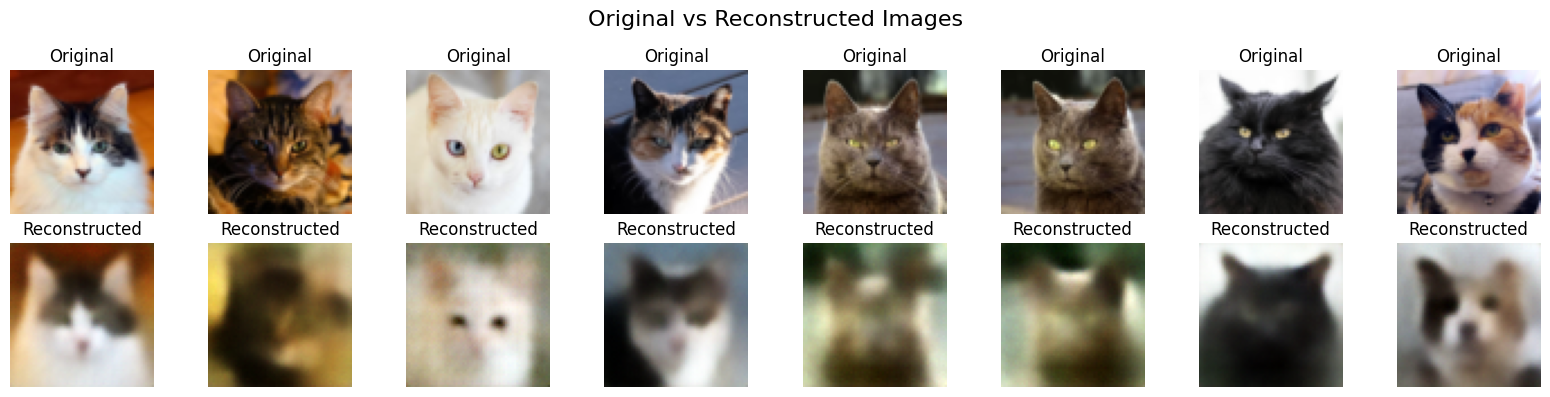

In [29]:
data_iter = iter(val_loader)
images, _ = next(data_iter)
visualize_reconstructions(model, images, device)

#### <font color='red'>6. Model with kl_weight=2</font>

In [30]:
# Model training parameters
learning_rate=0.0001
step_size=10
gamma=0.5

kl_weight=2

num_epochs=40

name=f"run_kl_wgt_{str(kl_weight)}_ep_{num_epochs}"
project="assignment-5"


latent_dim = 512 # define latent dimension

# Load model
model = ConvVAE(latent_dim=latent_dim).to(device)
# model

model = run_vae_training(
    model, train_loader, val_loader, device, 
    num_epochs=num_epochs, learning_rate=learning_rate,
    step_size=step_size, gamma=gamma,
    kl_weight=kl_weight,
    name=name, project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

Training Name: run_kl_wgt_2_ep_40
Total num. of Epochs: 40
Learning Rate: 0.0001
KL Weight used for Loss function: 2



  2%|█▍                                                      | 1/40 [01:26<56:06, 86.32s/it]


Epoch 1/40
Learning Rate: 0.000100
Train - Total: 1644.5830, Recon: 1460.1591, KL: 92.2120
Eval  - Total: 1624.9516, Recon: 1441.2056, KL: 91.8730


  5%|██▊                                                     | 2/40 [01:38<26:54, 42.49s/it]


Epoch 2/40
Learning Rate: 0.000100
Train - Total: 1236.1280, Recon: 1024.0159, KL: 106.0560
Eval  - Total: 1430.5092, Recon: 1220.4766, KL: 105.0163


  8%|████▏                                                   | 3/40 [01:49<17:25, 28.26s/it]


Epoch 3/40
Learning Rate: 0.000100
Train - Total: 1145.0251, Recon: 921.7977, KL: 111.6137
Eval  - Total: 1096.6253, Recon: 873.7296, KL: 111.4478


 10%|█████▌                                                  | 4/40 [02:00<12:55, 21.54s/it]


Epoch 4/40
Learning Rate: 0.000100
Train - Total: 1070.1083, Recon: 843.8662, KL: 113.1210
Eval  - Total: 1052.3206, Recon: 838.4579, KL: 106.9314


 12%|███████                                                 | 5/40 [02:12<10:33, 18.09s/it]


Epoch 5/40
Learning Rate: 0.000100
Train - Total: 1025.4790, Recon: 801.2383, KL: 112.1204
Eval  - Total: 936.7414, Recon: 714.3062, KL: 111.2176


 15%|████████▍                                               | 6/40 [02:24<09:06, 16.09s/it]


Epoch 6/40
Learning Rate: 0.000100
Train - Total: 984.2076, Recon: 764.5010, KL: 109.8533
Eval  - Total: 927.8659, Recon: 716.1680, KL: 105.8490


 18%|█████████▊                                              | 7/40 [02:36<07:58, 14.49s/it]


Epoch 7/40
Learning Rate: 0.000100
Train - Total: 959.2664, Recon: 741.0678, KL: 109.0993
Eval  - Total: 897.6630, Recon: 687.0908, KL: 105.2861


 20%|███████████▏                                            | 8/40 [02:47<07:10, 13.46s/it]


Epoch 8/40
Learning Rate: 0.000100
Train - Total: 930.5790, Recon: 716.7156, KL: 106.9317
Eval  - Total: 901.2570, Recon: 692.1734, KL: 104.5418


 22%|████████████▌                                           | 9/40 [02:59<06:42, 13.00s/it]


Epoch 9/40
Learning Rate: 0.000100
Train - Total: 911.3521, Recon: 700.5750, KL: 105.3886
Eval  - Total: 842.8174, Recon: 635.6201, KL: 103.5986


 25%|█████████████▊                                         | 10/40 [03:10<06:16, 12.54s/it]


Epoch 10/40
Learning Rate: 0.000100
Train - Total: 892.1838, Recon: 682.8640, KL: 104.6599
Eval  - Total: 845.9836, Recon: 635.0281, KL: 105.4778


 28%|███████████████▏                                       | 11/40 [03:22<05:54, 12.23s/it]


Epoch 11/40
Learning Rate: 0.000050
Train - Total: 861.3690, Recon: 658.0393, KL: 101.6649
Eval  - Total: 803.1688, Recon: 609.0823, KL: 97.0433


 30%|████████████████▌                                      | 12/40 [03:33<05:34, 11.94s/it]


Epoch 12/40
Learning Rate: 0.000050
Train - Total: 853.9950, Recon: 652.2869, KL: 100.8541
Eval  - Total: 780.7032, Recon: 586.3472, KL: 97.1780


 32%|█████████████████▉                                     | 13/40 [03:44<05:15, 11.69s/it]


Epoch 13/40
Learning Rate: 0.000050
Train - Total: 846.0584, Recon: 643.8559, KL: 101.1013
Eval  - Total: 778.2731, Recon: 584.8218, KL: 96.7257


 35%|███████████████████▎                                   | 14/40 [03:55<04:58, 11.49s/it]


Epoch 14/40
Learning Rate: 0.000050
Train - Total: 839.1212, Recon: 637.3346, KL: 100.8933
Eval  - Total: 779.0582, Recon: 584.8107, KL: 97.1237


 38%|████████████████████▋                                  | 15/40 [04:07<04:48, 11.53s/it]


Epoch 15/40
Learning Rate: 0.000050
Train - Total: 832.9649, Recon: 630.2937, KL: 101.3356
Eval  - Total: 791.4210, Recon: 599.7730, KL: 95.8240


 40%|██████████████████████                                 | 16/40 [04:19<04:40, 11.67s/it]


Epoch 16/40
Learning Rate: 0.000050
Train - Total: 827.5964, Recon: 625.0425, KL: 101.2770
Eval  - Total: 834.1048, Recon: 642.4914, KL: 95.8067


 42%|███████████████████████▍                               | 17/40 [04:31<04:28, 11.68s/it]


Epoch 17/40
Learning Rate: 0.000050
Train - Total: 823.5689, Recon: 620.1866, KL: 101.6911
Eval  - Total: 857.0815, Recon: 662.5615, KL: 97.2600


 45%|████████████████████████▊                              | 18/40 [04:42<04:18, 11.73s/it]


Epoch 18/40
Learning Rate: 0.000050
Train - Total: 817.3736, Recon: 613.1986, KL: 102.0875
Eval  - Total: 866.0923, Recon: 669.0036, KL: 98.5444


 48%|██████████████████████████▏                            | 19/40 [04:54<04:06, 11.73s/it]


Epoch 19/40
Learning Rate: 0.000050
Train - Total: 811.9280, Recon: 607.3802, KL: 102.2739
Eval  - Total: 835.3037, Recon: 628.2002, KL: 103.5517


 50%|███████████████████████████▌                           | 20/40 [05:06<03:55, 11.77s/it]


Epoch 20/40
Learning Rate: 0.000050
Train - Total: 807.3923, Recon: 602.5018, KL: 102.4452
Eval  - Total: 809.9142, Recon: 611.4393, KL: 99.2375


 52%|████████████████████████████▉                          | 21/40 [05:18<03:43, 11.79s/it]


Epoch 21/40
Learning Rate: 0.000025
Train - Total: 793.6872, Recon: 591.3013, KL: 101.1930
Eval  - Total: 779.8833, Recon: 588.9157, KL: 95.4838


 55%|██████████████████████████████▎                        | 22/40 [05:31<03:38, 12.15s/it]


Epoch 22/40
Learning Rate: 0.000025
Train - Total: 789.4750, Recon: 586.4573, KL: 101.5088
Eval  - Total: 793.3067, Recon: 597.0183, KL: 98.1442


 57%|███████████████████████████████▌                       | 23/40 [05:42<03:22, 11.91s/it]


Epoch 23/40
Learning Rate: 0.000025
Train - Total: 789.1353, Recon: 585.8840, KL: 101.6257
Eval  - Total: 782.0815, Recon: 586.1425, KL: 97.9695


 60%|█████████████████████████████████                      | 24/40 [05:53<03:04, 11.54s/it]


Epoch 24/40
Learning Rate: 0.000025
Train - Total: 785.6986, Recon: 582.8430, KL: 101.4278
Eval  - Total: 769.9354, Recon: 574.8943, KL: 97.5205


 62%|██████████████████████████████████▍                    | 25/40 [06:04<02:49, 11.28s/it]


Epoch 25/40
Learning Rate: 0.000025
Train - Total: 782.8220, Recon: 579.6217, KL: 101.6002
Eval  - Total: 779.3614, Recon: 587.3573, KL: 96.0020


 65%|███████████████████████████████████▊                   | 26/40 [06:15<02:37, 11.24s/it]


Epoch 26/40
Learning Rate: 0.000025
Train - Total: 780.4013, Recon: 577.1015, KL: 101.6499
Eval  - Total: 762.5497, Recon: 568.2585, KL: 97.1456


 68%|█████████████████████████████████████▏                 | 27/40 [06:27<02:28, 11.42s/it]


Epoch 27/40
Learning Rate: 0.000025
Train - Total: 778.8246, Recon: 574.6936, KL: 102.0655
Eval  - Total: 746.1851, Recon: 549.2618, KL: 98.4616


 70%|██████████████████████████████████████▌                | 28/40 [06:38<02:15, 11.32s/it]


Epoch 28/40
Learning Rate: 0.000025
Train - Total: 777.2500, Recon: 572.8928, KL: 102.1786
Eval  - Total: 744.0487, Recon: 546.4149, KL: 98.8169


 72%|███████████████████████████████████████▉               | 29/40 [06:49<02:04, 11.31s/it]


Epoch 29/40
Learning Rate: 0.000025
Train - Total: 775.5479, Recon: 571.2683, KL: 102.1398
Eval  - Total: 749.1176, Recon: 556.2880, KL: 96.4148


 75%|█████████████████████████████████████████▎             | 30/40 [07:01<01:54, 11.49s/it]


Epoch 30/40
Learning Rate: 0.000025
Train - Total: 772.4835, Recon: 568.0412, KL: 102.2211
Eval  - Total: 740.7636, Recon: 538.9768, KL: 100.8934


 78%|██████████████████████████████████████████▋            | 31/40 [07:12<01:42, 11.43s/it]


Epoch 31/40
Learning Rate: 0.000013
Train - Total: 767.8113, Recon: 564.1445, KL: 101.8334
Eval  - Total: 723.5773, Recon: 530.6301, KL: 96.4736


 80%|████████████████████████████████████████████           | 32/40 [07:23<01:30, 11.34s/it]


Epoch 32/40
Learning Rate: 0.000013
Train - Total: 765.0928, Recon: 561.0874, KL: 102.0027
Eval  - Total: 727.7822, Recon: 531.7800, KL: 98.0011


 82%|█████████████████████████████████████████████▍         | 33/40 [07:34<01:18, 11.19s/it]


Epoch 33/40
Learning Rate: 0.000013
Train - Total: 764.7268, Recon: 561.1586, KL: 101.7841
Eval  - Total: 718.3629, Recon: 521.3451, KL: 98.5089


 85%|██████████████████████████████████████████████▊        | 34/40 [07:45<01:06, 11.13s/it]


Epoch 34/40
Learning Rate: 0.000013
Train - Total: 764.7216, Recon: 560.5085, KL: 102.1066
Eval  - Total: 728.3327, Recon: 529.8466, KL: 99.2431


 88%|████████████████████████████████████████████████▏      | 35/40 [07:56<00:55, 11.03s/it]


Epoch 35/40
Learning Rate: 0.000013
Train - Total: 762.6508, Recon: 558.6566, KL: 101.9971
Eval  - Total: 720.9643, Recon: 525.1741, KL: 97.8951


 90%|█████████████████████████████████████████████████▌     | 36/40 [08:07<00:43, 10.98s/it]


Epoch 36/40
Learning Rate: 0.000013
Train - Total: 762.3882, Recon: 558.4098, KL: 101.9892
Eval  - Total: 719.4133, Recon: 524.2201, KL: 97.5966


 92%|██████████████████████████████████████████████████▉    | 37/40 [08:18<00:33, 11.02s/it]


Epoch 37/40
Learning Rate: 0.000013
Train - Total: 761.1530, Recon: 556.8354, KL: 102.1588
Eval  - Total: 717.0526, Recon: 520.1401, KL: 98.4563


 95%|████████████████████████████████████████████████████▎  | 38/40 [08:28<00:21, 10.89s/it]


Epoch 38/40
Learning Rate: 0.000013
Train - Total: 758.5530, Recon: 554.2030, KL: 102.1750
Eval  - Total: 709.8979, Recon: 511.8832, KL: 99.0073


 98%|█████████████████████████████████████████████████████▋ | 39/40 [08:39<00:10, 10.82s/it]


Epoch 39/40
Learning Rate: 0.000013
Train - Total: 759.0940, Recon: 554.4450, KL: 102.3245
Eval  - Total: 712.6114, Recon: 516.4167, KL: 98.0973


100%|███████████████████████████████████████████████████████| 40/40 [08:50<00:00, 13.26s/it]


Epoch 40/40
Learning Rate: 0.000013
Train - Total: 758.4840, Recon: 554.0030, KL: 102.2405
Eval  - Total: 716.7394, Recon: 521.2206, KL: 97.7594


Model saved at: ./saved_models/run_kl_wgt_2_ep_40


In [31]:
model = load_model(save_path)
max_samples = min(2000, len(val_loader.dataset))
fid_score = compute_fid_score(model, val_loader, device, max_samples=max_samples)
print(f"FID Score for model {name}: {fid_score}")

/tmp/ipykernel_1733915/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FID Score for model run_kl_wgt_2_ep_40: 163.14988708496094


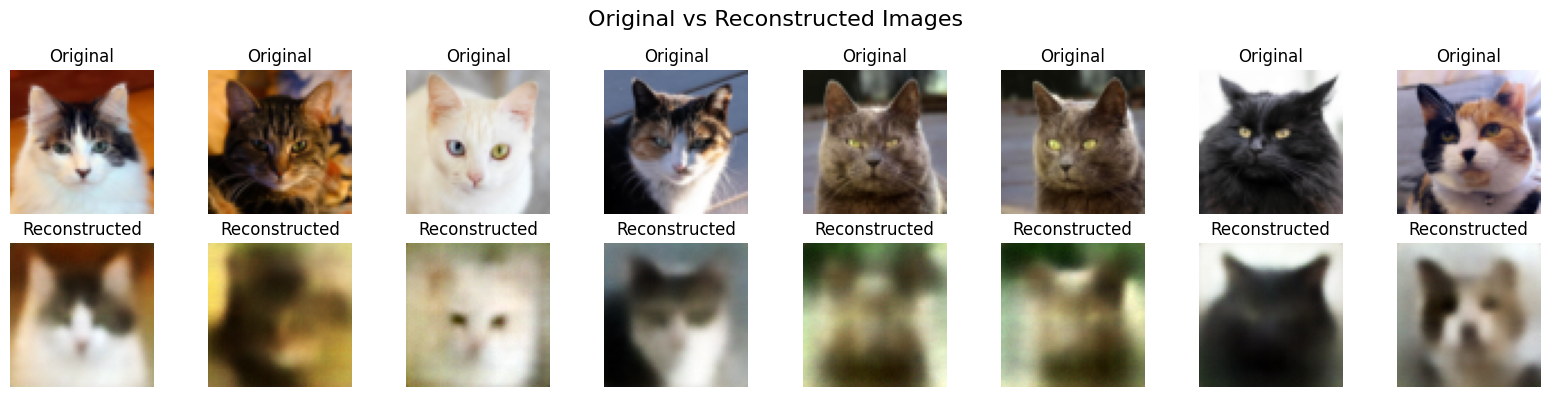

In [32]:
data_iter = iter(val_loader)
images, _ = next(data_iter)
visualize_reconstructions(model, images, device)

#### <font color='red'>7. Model with kl_weight=2</font>

In [33]:
# Model training parameters
learning_rate=0.0001
step_size=10
gamma=0.5

kl_weight=2

num_epochs=40

name=f"run_kl_wgt_{str(kl_weight)}_ep_{num_epochs}_ld_1024"
project="assignment-5"


latent_dim = 512 # define latent dimension

# Load model
model = ConvVAE(latent_dim=latent_dim).to(device)
# model

model = run_vae_training(
    model, train_loader, val_loader, device, 
    num_epochs=num_epochs, learning_rate=learning_rate,
    step_size=step_size, gamma=gamma,
    kl_weight=kl_weight,
    name=name, project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

Training Name: run_kl_wgt_0.01_ep_40_ld_1024
Total num. of Epochs: 40
Learning Rate: 0.0001
KL Weight used for Loss function: 0.01



  2%|█▍                                                      | 1/40 [01:24<54:50, 84.38s/it]


Epoch 1/40
Learning Rate: 0.000100
Train - Total: 1154.9244, Recon: 1134.1689, KL: 2075.5476
Eval  - Total: 630.9988, Recon: 612.8309, KL: 1816.7986


  5%|██▊                                                     | 2/40 [01:34<25:51, 40.84s/it]


Epoch 2/40
Learning Rate: 0.000100
Train - Total: 566.8764, Recon: 546.7244, KL: 2015.1942
Eval  - Total: 490.5365, Recon: 468.8341, KL: 2170.2425


  8%|████▏                                                   | 3/40 [01:45<16:36, 26.94s/it]


Epoch 3/40
Learning Rate: 0.000100
Train - Total: 470.4485, Recon: 448.4661, KL: 2198.2334
Eval  - Total: 433.9574, Recon: 411.4063, KL: 2255.1080


 10%|█████▌                                                  | 4/40 [01:55<12:15, 20.43s/it]


Epoch 4/40
Learning Rate: 0.000100
Train - Total: 421.1350, Recon: 398.1540, KL: 2298.1012
Eval  - Total: 379.4032, Recon: 356.2218, KL: 2318.1385


 12%|███████                                                 | 5/40 [02:06<09:49, 16.83s/it]


Epoch 5/40
Learning Rate: 0.000100
Train - Total: 386.4770, Recon: 362.7381, KL: 2373.8828
Eval  - Total: 358.6745, Recon: 334.9959, KL: 2367.8565


 15%|████████▍                                               | 6/40 [02:16<08:17, 14.63s/it]


Epoch 6/40
Learning Rate: 0.000100
Train - Total: 363.7354, Recon: 339.5416, KL: 2419.3834
Eval  - Total: 349.6400, Recon: 325.2585, KL: 2438.1507


 18%|█████████▊                                              | 7/40 [02:26<07:18, 13.30s/it]


Epoch 7/40
Learning Rate: 0.000100
Train - Total: 340.9522, Recon: 316.3058, KL: 2464.6388
Eval  - Total: 323.0208, Recon: 298.0481, KL: 2497.2672


 20%|███████████▏                                            | 8/40 [02:37<06:37, 12.42s/it]


Epoch 8/40
Learning Rate: 0.000100
Train - Total: 321.2611, Recon: 296.2658, KL: 2499.5308
Eval  - Total: 318.7402, Recon: 293.3513, KL: 2538.8937


 22%|████████████▌                                           | 9/40 [02:47<06:06, 11.82s/it]


Epoch 9/40
Learning Rate: 0.000100
Train - Total: 308.5479, Recon: 283.2437, KL: 2530.4150
Eval  - Total: 286.7459, Recon: 261.6400, KL: 2510.5884


 25%|█████████████▊                                         | 10/40 [02:58<05:44, 11.50s/it]


Epoch 10/40
Learning Rate: 0.000100
Train - Total: 295.1237, Recon: 269.6552, KL: 2546.8424
Eval  - Total: 296.3434, Recon: 270.5361, KL: 2580.7245


 28%|███████████████▏                                       | 11/40 [03:09<05:26, 11.27s/it]


Epoch 11/40
Learning Rate: 0.000050
Train - Total: 275.5254, Recon: 250.3000, KL: 2522.5444
Eval  - Total: 265.6496, Recon: 240.9653, KL: 2468.4285


 30%|████████████████▌                                      | 12/40 [03:20<05:13, 11.19s/it]


Epoch 12/40
Learning Rate: 0.000050
Train - Total: 265.7921, Recon: 241.0736, KL: 2471.8444
Eval  - Total: 251.9425, Recon: 227.7702, KL: 2417.2261


 32%|█████████████████▉                                     | 13/40 [03:31<04:58, 11.06s/it]


Epoch 13/40
Learning Rate: 0.000050
Train - Total: 260.5675, Recon: 236.1245, KL: 2444.3038
Eval  - Total: 247.3945, Recon: 223.4606, KL: 2393.3886


 35%|███████████████████▎                                   | 14/40 [03:42<04:47, 11.06s/it]


Epoch 14/40
Learning Rate: 0.000050
Train - Total: 257.4692, Recon: 233.1834, KL: 2428.5796
Eval  - Total: 245.7229, Recon: 221.7502, KL: 2397.2703


 38%|████████████████████▋                                  | 15/40 [03:52<04:30, 10.81s/it]


Epoch 15/40
Learning Rate: 0.000050
Train - Total: 251.6409, Recon: 227.4048, KL: 2423.6128
Eval  - Total: 243.1579, Recon: 219.1488, KL: 2400.9006


 40%|██████████████████████                                 | 16/40 [04:03<04:17, 10.74s/it]


Epoch 16/40
Learning Rate: 0.000050
Train - Total: 253.7617, Recon: 229.4755, KL: 2428.6260
Eval  - Total: 255.7139, Recon: 231.4971, KL: 2421.6822


 42%|███████████████████████▍                               | 17/40 [04:13<04:06, 10.72s/it]


Epoch 17/40
Learning Rate: 0.000050
Train - Total: 242.1393, Recon: 217.8369, KL: 2430.2391
Eval  - Total: 237.7767, Recon: 213.9279, KL: 2384.8825


 45%|████████████████████████▊                              | 18/40 [04:24<03:55, 10.69s/it]


Epoch 18/40
Learning Rate: 0.000050
Train - Total: 238.6071, Recon: 214.3824, KL: 2422.4758
Eval  - Total: 235.7258, Recon: 211.9176, KL: 2380.8128


 48%|██████████████████████████▏                            | 19/40 [04:34<03:43, 10.63s/it]


Epoch 19/40
Learning Rate: 0.000050
Train - Total: 233.8468, Recon: 209.6672, KL: 2417.9576
Eval  - Total: 239.0762, Recon: 215.3482, KL: 2372.8033


 50%|███████████████████████████▌                           | 20/40 [04:45<03:31, 10.57s/it]


Epoch 20/40
Learning Rate: 0.000050
Train - Total: 230.8683, Recon: 206.6210, KL: 2424.7301
Eval  - Total: 235.4871, Recon: 211.5577, KL: 2392.9433


 52%|████████████████████████████▉                          | 21/40 [04:55<03:17, 10.41s/it]


Epoch 21/40
Learning Rate: 0.000025
Train - Total: 220.2229, Recon: 196.0961, KL: 2412.6879
Eval  - Total: 218.5031, Recon: 194.6196, KL: 2388.3525


 55%|██████████████████████████████▎                        | 22/40 [05:06<03:10, 10.59s/it]


Epoch 22/40
Learning Rate: 0.000025
Train - Total: 217.5097, Recon: 193.5490, KL: 2396.0719
Eval  - Total: 215.8283, Recon: 192.1745, KL: 2365.3882


 57%|███████████████████████████████▌                       | 23/40 [05:16<02:58, 10.50s/it]


Epoch 23/40
Learning Rate: 0.000025
Train - Total: 214.3606, Recon: 190.4914, KL: 2386.9230
Eval  - Total: 214.0448, Recon: 190.3166, KL: 2372.8126


 60%|█████████████████████████████████                      | 24/40 [05:27<02:47, 10.45s/it]


Epoch 24/40
Learning Rate: 0.000025
Train - Total: 212.9375, Recon: 189.1553, KL: 2378.2264
Eval  - Total: 215.9207, Recon: 192.3540, KL: 2356.6711


 62%|██████████████████████████████████▍                    | 25/40 [05:37<02:36, 10.44s/it]


Epoch 25/40
Learning Rate: 0.000025
Train - Total: 210.0252, Recon: 186.3070, KL: 2371.8224
Eval  - Total: 211.9516, Recon: 188.6586, KL: 2329.3003


 65%|███████████████████████████████████▊                   | 26/40 [05:48<02:29, 10.70s/it]


Epoch 26/40
Learning Rate: 0.000025
Train - Total: 208.4510, Recon: 184.7800, KL: 2367.1077
Eval  - Total: 211.1954, Recon: 187.8648, KL: 2333.0629


 68%|█████████████████████████████████████▏                 | 27/40 [05:59<02:18, 10.63s/it]


Epoch 27/40
Learning Rate: 0.000025
Train - Total: 205.7422, Recon: 182.1008, KL: 2364.1480
Eval  - Total: 209.4097, Recon: 186.0348, KL: 2337.4915


 70%|██████████████████████████████████████▌                | 28/40 [06:10<02:09, 10.76s/it]


Epoch 28/40
Learning Rate: 0.000025
Train - Total: 204.5504, Recon: 180.9448, KL: 2360.5575
Eval  - Total: 210.2672, Recon: 186.7093, KL: 2355.7901


 72%|███████████████████████████████████████▉               | 29/40 [06:20<01:57, 10.68s/it]


Epoch 29/40
Learning Rate: 0.000025
Train - Total: 202.5252, Recon: 178.9349, KL: 2359.0377
Eval  - Total: 206.8666, Recon: 183.2307, KL: 2363.5940


 75%|█████████████████████████████████████████▎             | 30/40 [06:31<01:47, 10.75s/it]


Epoch 30/40
Learning Rate: 0.000025
Train - Total: 200.4027, Recon: 176.8518, KL: 2355.0890
Eval  - Total: 204.1422, Recon: 180.8794, KL: 2326.2836


 78%|██████████████████████████████████████████▋            | 31/40 [06:42<01:35, 10.66s/it]


Epoch 31/40
Learning Rate: 0.000013
Train - Total: 194.8690, Recon: 171.3471, KL: 2352.1821
Eval  - Total: 200.7565, Recon: 177.7990, KL: 2295.7535


 80%|████████████████████████████████████████████           | 32/40 [06:52<01:24, 10.60s/it]


Epoch 32/40
Learning Rate: 0.000013
Train - Total: 193.7747, Recon: 170.3050, KL: 2346.9732
Eval  - Total: 200.1824, Recon: 176.8756, KL: 2330.6833


 82%|█████████████████████████████████████████████▍         | 33/40 [07:02<01:13, 10.53s/it]


Epoch 33/40
Learning Rate: 0.000013
Train - Total: 193.3461, Recon: 169.9181, KL: 2342.7975
Eval  - Total: 201.0283, Recon: 177.9099, KL: 2311.8352


 85%|██████████████████████████████████████████████▊        | 34/40 [07:14<01:04, 10.70s/it]


Epoch 34/40
Learning Rate: 0.000013
Train - Total: 192.3207, Recon: 168.8894, KL: 2343.1295
Eval  - Total: 199.4604, Recon: 176.1500, KL: 2331.0404


 88%|████████████████████████████████████████████████▏      | 35/40 [07:24<00:53, 10.62s/it]


Epoch 35/40
Learning Rate: 0.000013
Train - Total: 190.6421, Recon: 167.2715, KL: 2337.0591
Eval  - Total: 199.3370, Recon: 176.5710, KL: 2276.6065


 90%|█████████████████████████████████████████████████▌     | 36/40 [07:34<00:41, 10.47s/it]


Epoch 36/40
Learning Rate: 0.000013
Train - Total: 190.6297, Recon: 167.2563, KL: 2337.3380
Eval  - Total: 198.7034, Recon: 175.8611, KL: 2284.2294


 92%|██████████████████████████████████████████████████▉    | 37/40 [07:45<00:31, 10.45s/it]


Epoch 37/40
Learning Rate: 0.000013
Train - Total: 188.9159, Recon: 165.5631, KL: 2335.2762
Eval  - Total: 198.0970, Recon: 174.9808, KL: 2311.6225


 95%|████████████████████████████████████████████████████▎  | 38/40 [07:56<00:21, 10.78s/it]


Epoch 38/40
Learning Rate: 0.000013
Train - Total: 188.8408, Recon: 165.5096, KL: 2333.1229
Eval  - Total: 200.3036, Recon: 177.4527, KL: 2285.0956


 98%|█████████████████████████████████████████████████████▋ | 39/40 [08:06<00:10, 10.62s/it]


Epoch 39/40
Learning Rate: 0.000013
Train - Total: 187.4149, Recon: 164.0908, KL: 2332.4086
Eval  - Total: 197.3519, Recon: 174.3637, KL: 2298.8142


100%|███████████████████████████████████████████████████████| 40/40 [08:17<00:00, 12.43s/it]


Epoch 40/40
Learning Rate: 0.000013
Train - Total: 186.2165, Recon: 162.9184, KL: 2329.8193
Eval  - Total: 196.0076, Recon: 173.0605, KL: 2294.7107


Model saved at: ./saved_models/run_kl_wgt_0.01_ep_40_ld_1024


In [34]:
model = load_model(save_path)
max_samples = min(2000, len(val_loader.dataset))
fid_score = compute_fid_score(model, val_loader, device, max_samples=max_samples)
print(f"FID Score for model {name}: {fid_score}")

/tmp/ipykernel_1733915/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FID Score for model run_kl_wgt_0.01_ep_40_ld_1024: 102.53485870361328


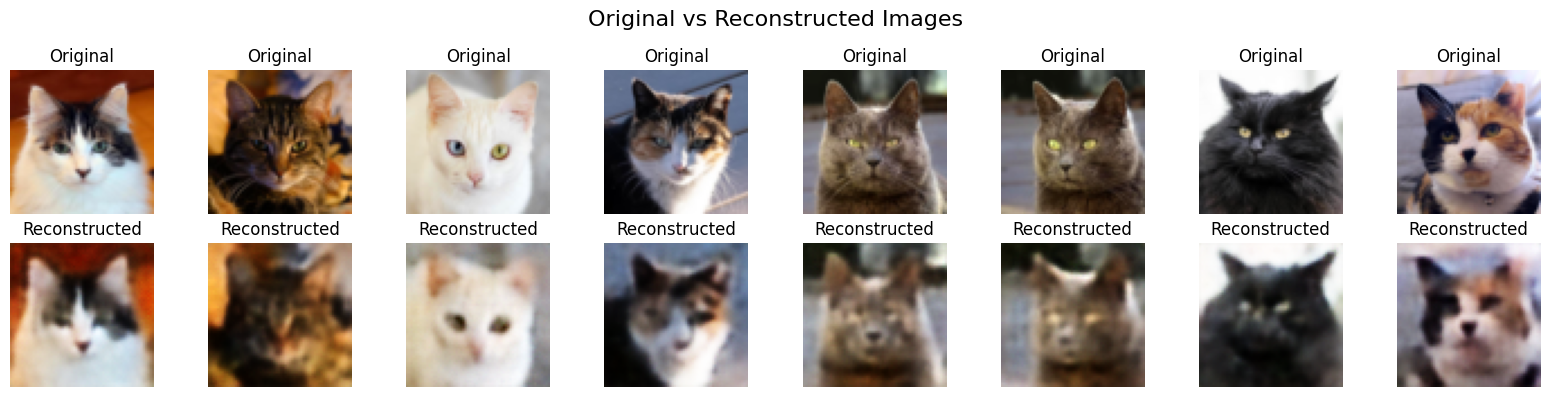

In [35]:
data_iter = iter(val_loader)
images, _ = next(data_iter)
visualize_reconstructions(model, images, device)

In [15]:
def normalize_image(image):
    """
    Normalize image data to the range [0, 1].
    """
    min_val = image.min()
    max_val = image.max()
    return (image - min_val) / (max_val - min_val)


In [16]:
def sample_latent_vectors(model, num_samples, latent_dim, device):
    # Sample random latent vectors from a standard normal distribution
    z = torch.randn(num_samples, latent_dim).to(device)
    # Generate images using the decoder
    model.eval()
    with torch.no_grad():
        generated_images = model.decoder(z)  # No skip connection needed for random sampling
        # generated_images = generated_images.reshape(num_samples, 1, 64, 64)
    return generated_images

In [17]:
def interpolate_latent_space(model, latent_dim, steps, device):
    # Randomly sample two latent vectors
    z1 = torch.randn(1, latent_dim).to(device)
    z2 = torch.randn(1, latent_dim).to(device)
    
    # Create interpolation vectors
    interpolated_z = torch.cat(
        [z1 + (t / (steps - 1)) * (z2 - z1) for t in range(steps)], dim=0
    )
    
    # Generate images from the interpolated latent vectors
    model.eval()
    with torch.no_grad():
        interpolated_images = model.decoder(interpolated_z)
    return interpolated_images

In [28]:
def visualize_images(images, num_rows, num_cols):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(images, axs):
        # Convert tensor to numpy and transpose to HWC for plotting
        ax.imshow(img.permute(1, 2, 0).cpu().numpy())
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [19]:
def visualize_images(images, num_rows, num_cols):
    """
    Visualize a grid of images.
    """
    fig, axes = plt.subplots(num_rows, num_cols)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(images):
            # Transpose image dimensions from [C, H, W] to [H, W, C] for imshow
            ax.imshow(np.transpose(images[i], (1, 2, 0)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# visualize_images(normalized_images, num_rows=4, num_cols=4)


/tmp/ipykernel_3299892/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


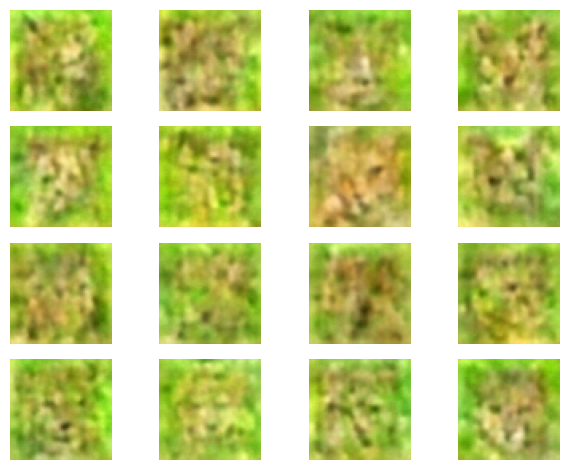

In [20]:
# Define parameters
num_samples = 16  # Number of images to generate
latent_dim = 128  # Must match your model's latent dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate images
model = load_model("./saved_models/run_kl_wgt_0.01_ep_40_latent_dim_128")
generated_images = sample_latent_vectors(model, num_samples, latent_dim, device)

# Normalize generated images
generated_images = generated_images.cpu().numpy()  # Convert to NumPy array
normalized_images = np.array([normalize_image(img) for img in generated_images])

# Visualize the images
visualize_images(normalized_images, num_rows=4, num_cols=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.738746..0.63511026].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7103348..0.57357085].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6775458..0.5032407].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.65424204..0.4780399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64198464..0.4595739].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6326835..0.46665376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62

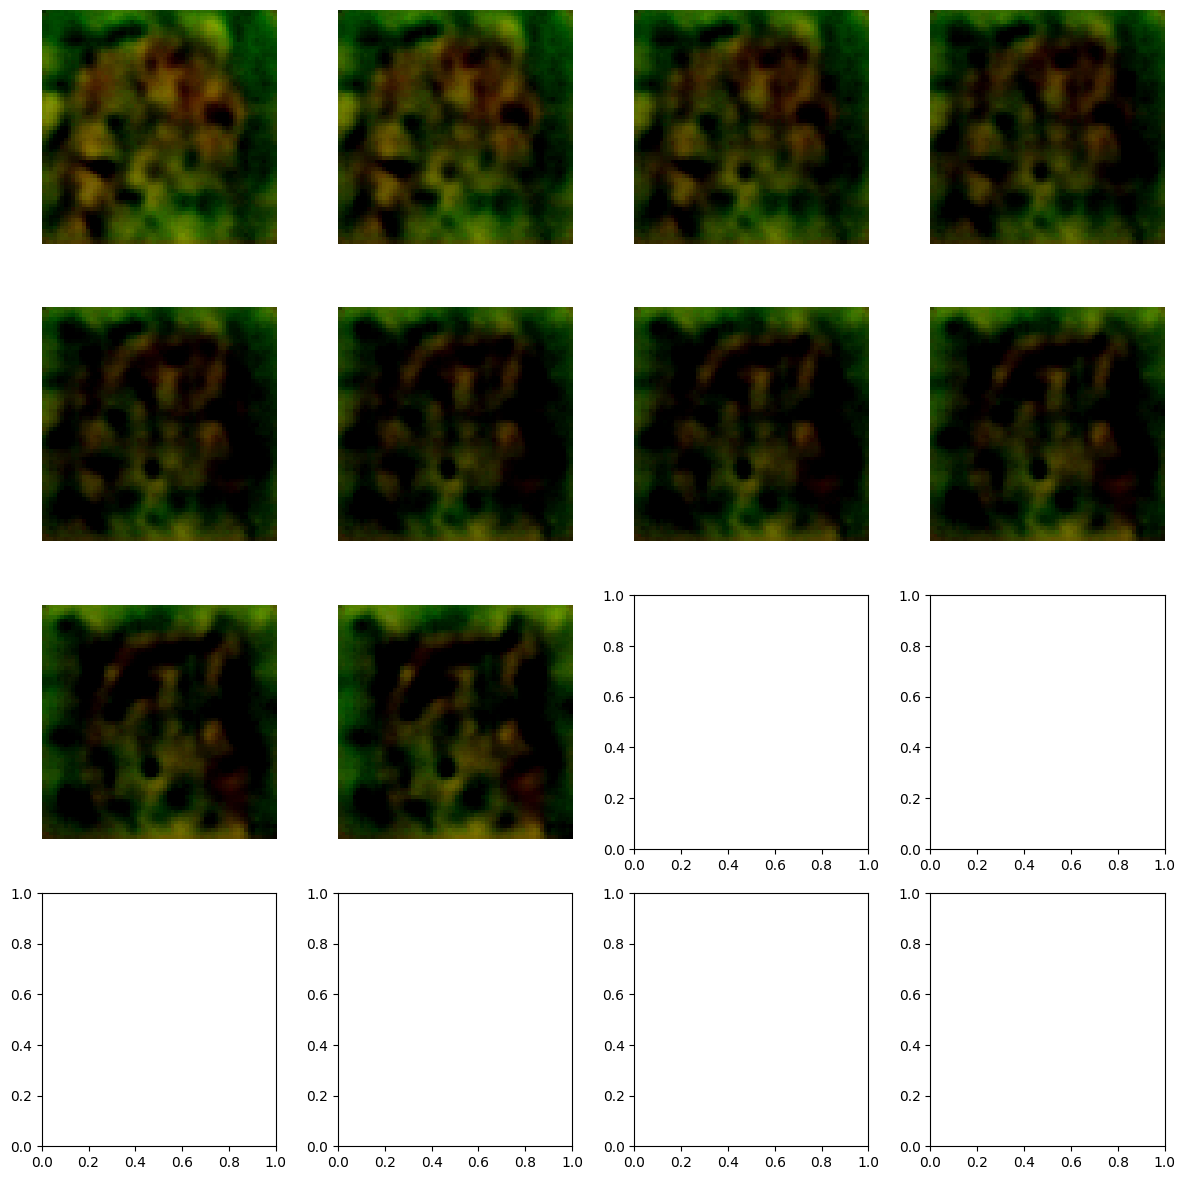

In [29]:
op = interpolate_latent_space(model,  latent_dim, steps=10, device=device)
visualize_images(op.to("cpu"), num_rows=4, num_cols=4)

In [66]:
# def sample_from_latent(model, num_samples=8, device="cuda", std_scale=0.7):
#     model.eval()
#     with torch.no_grad():
#         z = torch.randn(num_samples, model.encoder.fc_mu.out_features).to(device) * std_scale
#         z = torch.clamp(z, -2, 2)
#         samples = model.decoder(z)
        
#         samples = samples.cpu().permute(0, 2, 3, 1).numpy()
#         samples = (samples + 1) / 2  # Convert from [-1,1] to [0,1] due to tanh
        
#         plt.figure(figsize=(2*num_samples, 2))
#         for i in range(num_samples):
#             plt.subplot(1, num_samples, i+1)
#             plt.imshow(np.clip(samples[i], 0, 1))
#             plt.axis('off')
#         plt.show()

# def interpolate_latent(model, dataloader, num_steps=8, device="cuda"):
#     model.eval()
#     images, _ = next(iter(dataloader))
#     img1, img2 = images[:2].to(device)
    
#     with torch.no_grad():
#         mu1, log_var1 = model.encoder(img1.unsqueeze(0))
#         mu2, log_var2 = model.encoder(img2.unsqueeze(0))
        
#         alphas = np.linspace(0, 1, num_steps)
#         interp_images = []
        
#         for alpha in alphas:
#             z = mu1 * (1-alpha) + mu2 * alpha
#             decoded = model.decoder(z)
#             interp_images.append(decoded)
        
#         interp_images = torch.cat(interp_images).cpu().permute(0, 2, 3, 1).numpy()
#         interp_images = (interp_images + 1) / 2  # Convert from [-1,1] to [0,1]
        
#         plt.figure(figsize=(2*num_steps, 2))
#         for i in range(num_steps):
#             plt.subplot(1, num_steps, i+1)
#             plt.imshow(np.clip(interp_images[i], 0, 1))
#             plt.axis('off')
#         plt.title(f'α={alphas[i]:.2f}')
#         plt.show()

# def visualize_latent_2d(model, dataloader, num_samples=1000, device="cuda"):
#     model.eval()
#     latent_vectors = []
#     labels = []
    
#     with torch.no_grad():
#         for images, batch_labels in dataloader:
#             if len(latent_vectors) * images.size(0) >= num_samples:
#                 break
#             images = images.to(device)
#             mu, _ = model.encoder(images)
#             latent_vectors.append(mu.cpu())
#             labels.extend(batch_labels.tolist())
    
#     latent_vectors = torch.cat(latent_vectors, dim=0)[:num_samples]
#     labels = labels[:num_samples]
    
#     tsne = TSNE(n_components=2, random_state=42)
#     z_2d = tsne.fit_transform(latent_vectors.numpy())
    
#     plt.figure(figsize=(10, 8))
#     scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab10')
#     plt.colorbar(scatter)
#     plt.title("Latent Space t-SNE")
#     plt.show()

In [67]:
# sample_from_latent(model, num_samples=8, device=device, std_scale=1)

In [23]:
# interpolate_latent(model, val_loader, num_steps=10, device=device)

TypeError: randn(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got DataLoader"

In [69]:
# interpolate_latent(model, val_loader, num_steps=20, device=device)

In [70]:
# plot_latent_grid(model, xrange=(-3, 3), yrange=(-3, 3), n=8)

In [71]:
# def interpolate_latent_grid(model, dataloader, num_images=4, steps=8, device="cuda"):
#     """
#     Create a grid of interpolated images between multiple input images.
    
#     Args:
#         model: VAE model
#         dataloader: DataLoader containing images and labels
#         num_images: Number of source images to interpolate between
#         steps: Number of interpolation steps between each pair
#         device: Device to run the model on
#     """
#     model.eval()
    
#     # Get random images and their encodings
#     images, labels = next(iter(dataloader))
#     images = images[:num_images].to(device)
    
#     with torch.no_grad():
#         # Encode images to get latent vectors
#         mus, _ = model.encoder(images)
        
#         # Create empty grid to store interpolated images
#         grid_size = (num_images * steps, num_images * steps, 3)
#         grid = np.zeros(grid_size)
        
#         # Generate interpolations
#         for i in range(num_images):
#             for j in range(num_images):
#                 # Get source latent vectors
#                 z1 = mus[i]
#                 z2 = mus[j]
                
#                 # Create interpolation steps
#                 for step_i in range(steps):
#                     for step_j in range(steps):
#                         # Calculate interpolation weights
#                         alpha_i = step_i / (steps - 1)
#                         alpha_j = step_j / (steps - 1)
                        
#                         # Interpolate in latent space
#                         z = z1 * (1-alpha_i) * (1-alpha_j) + \
#                             z2 * alpha_i * alpha_j
                        
#                         # Decode interpolated vector
#                         decoded = model.decoder(z.unsqueeze(0))
#                         img = decoded.cpu().squeeze().permute(1, 2, 0).numpy()
                        
#                         # Convert from [-1,1] to [0,1] range
#                         img = (img + 1) / 2
                        
#                         # Place in grid
#                         grid[i*steps + step_i, j*steps + step_j] = img
        
#         # Plot the grid
#         plt.figure(figsize=(20, 20))
#         plt.imshow(np.clip(grid, 0, 1))
#         plt.title("Latent Space Grid Interpolation")
#         plt.axis('off')
        
#         # Add source image labels
#         for i, label in enumerate(labels[:num_images]):
#             plt.text(i*steps + steps//2, -5, f"Class {label.item()}", 
#                     ha='center', va='center')
#             plt.text(-5, i*steps + steps//2, f"Class {label.item()}", 
#                     ha='center', va='center')
        
#         plt.tight_layout()
#         plt.show()

In [72]:
# interpolate_latent_grid(model, val_loader, num_images=4, steps=8)


In [73]:
# # Define parameters
# steps = 10  # Number of interpolated images to generate
# latent_dim = 512  # Must match your model's latent dimension
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Generate interpolated images
# interpolated_images = interpolate_latent_space(model, latent_dim, steps, device)

# # Visualize the images
# visualize_images(interpolated_images, num_rows=1, num_cols=steps)

In [77]:
def visualize_latent_2d(model, dataloader, num_samples=1000, device="cuda"):
    model.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for images, batch_labels in dataloader:
            if len(latent_vectors) * images.size(0) >= num_samples:
                break
            images = images.to(device)
            mu, _ = model.encoder(images)
            latent_vectors.append(mu.cpu())
            labels.extend(batch_labels.tolist())
    
    latent_vectors = torch.cat(latent_vectors, dim=0)[:num_samples]
    labels = labels[:num_samples]
    
    tsne = TSNE(n_components=2, random_state=42)
    z_2d = tsne.fit_transform(latent_vectors.numpy())
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title("Latent Space t-SNE")
    plt.show()

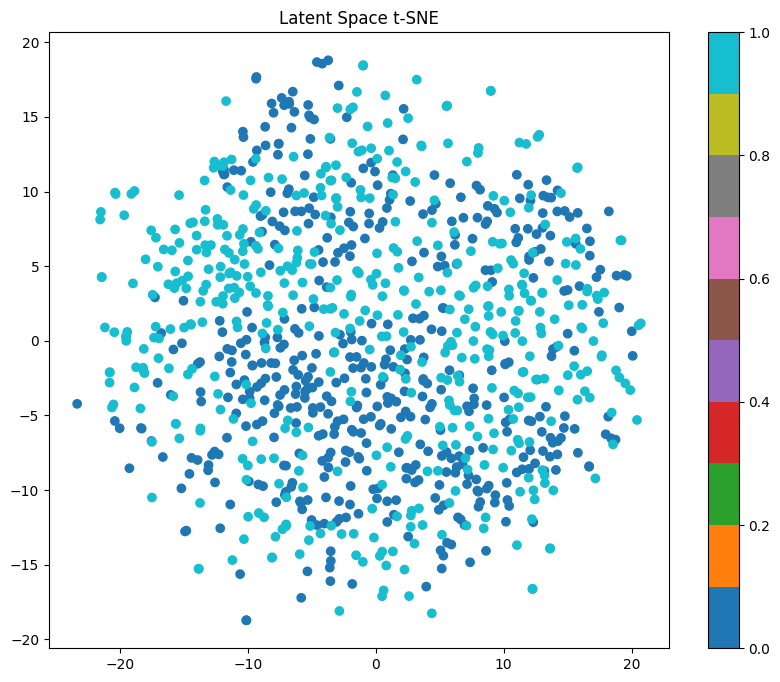

In [78]:
visualize_latent_2d(model, val_loader, num_samples=1000, device=device)

In [90]:
def display_projections(projections, labels, ax, title=None, legend=None):
    """
    Display 2D projections with a legend.
    Args:
        projections: 2D array of projections.
        labels: Class labels for each point.
        ax: Matplotlib axis to plot on.
        title: Optional title for the plot.
        legend: Optional legend labels (class names).
    """
    scatter = ax.scatter(projections[:, 0], projections[:, 1], c=labels, cmap='tab10', alpha=0.7)
    
    if title:
        ax.set_title(title)
    
    if legend:
        # Add legend with class names
        handles, _ = scatter.legend_elements()
        class_labels = [legend[label] for label in np.unique(labels)]
        ax.legend(handles, class_labels, title="Classes", loc="best")

In [121]:
def investigate_latent_space(model, dataloader, num_samples=2000, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Investigate latent space by encoding images and projecting latent representations using T-SNE.
    Args:
        model: Trained ConvVAE model.
        dataloader: DataLoader for the dataset.
        num_samples: Number of samples for T-SNE projection.
        device: Device to run the model on.
    """
    model.eval()
    latents = []
    labels = []
    images = []

    with torch.no_grad():
        for i, (img_batch, label_batch) in enumerate(dataloader):
            if len(latents) >= num_samples:
                break
            img_batch = img_batch.to(device)
            mu, _ = model.encoder(img_batch)
            latents.append(mu.cpu().numpy())
            labels.extend(label_batch.cpu().numpy())
            images.append(img_batch.cpu().numpy())
    
    latents = np.concatenate(latents)[:num_samples]
    labels = np.array(labels)[:num_samples]
    images = np.concatenate(images)[:num_samples]

    # Flatten images for TSNE visualization
    images_flat = images.reshape(images.shape[0], -1)
    
    # Apply T-SNE
    tsne_imgs = TSNE(n_components=2).fit_transform(images_flat)
    tsne_latents = TSNE(n_components=2).fit_transform(latents)
    
    # Visualize projections
    fig, ax = plt.subplots(1, 2, figsize=(26, 8))
    display_projections(tsne_imgs, labels, ax=ax[0], title="T-SNE Projection of Images", legend=['cat','dog','wild'])
    display_projections(tsne_latents, labels, ax=ax[1], title="T-SNE Projection of Latent Representations", legend=['cat','dog','wild'])
    plt.show()

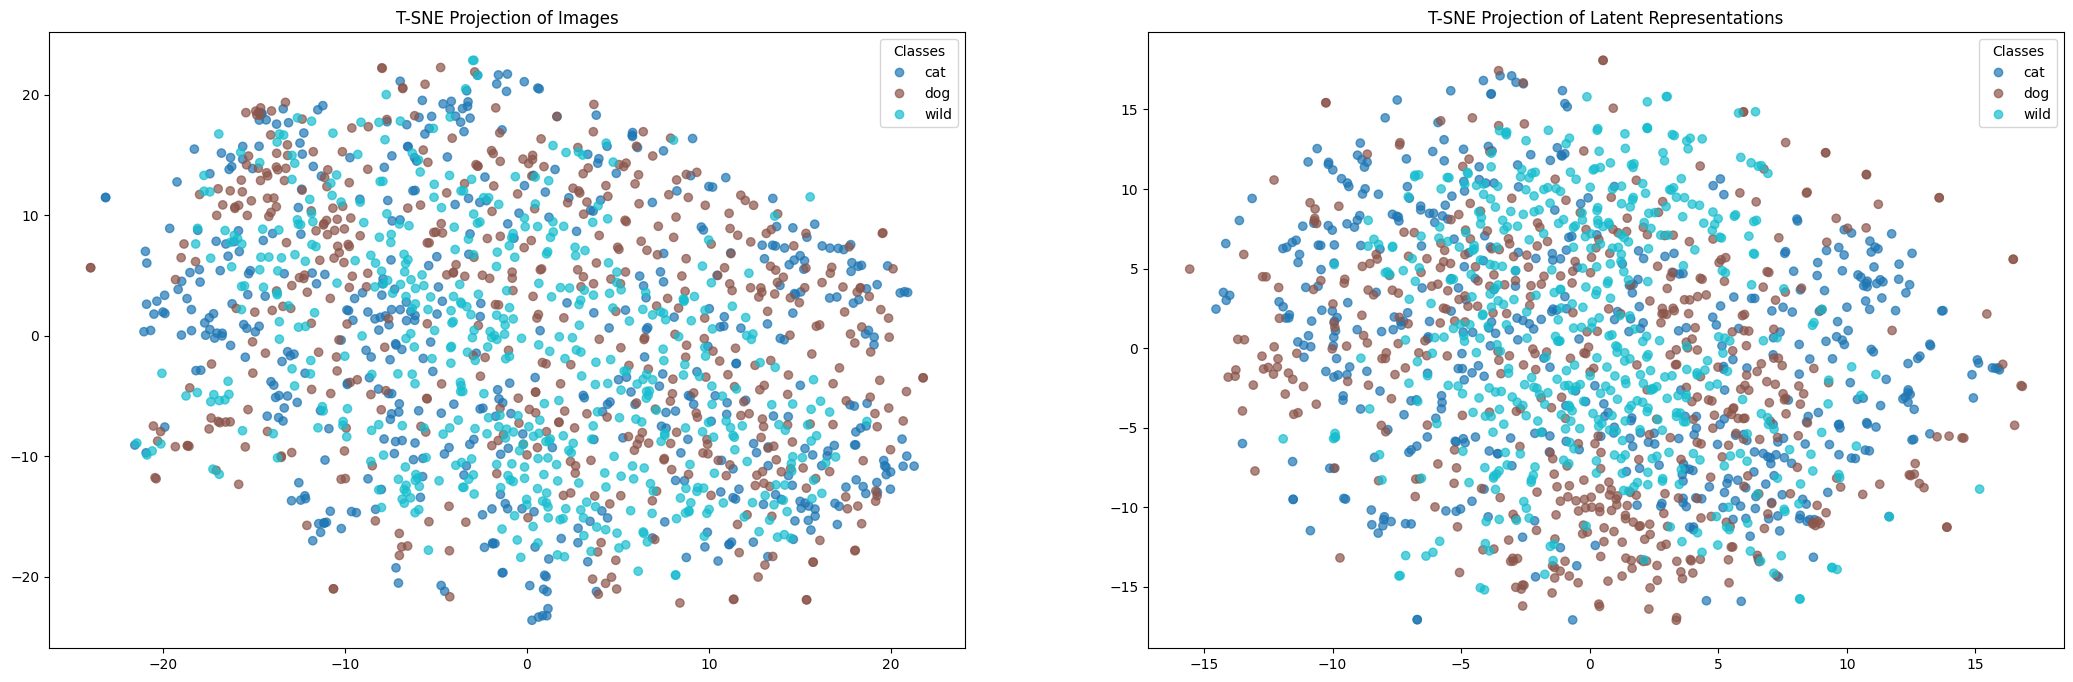

In [122]:
investigate_latent_space(model=model, dataloader=val_loader, num_samples=2000, device=device)


In [30]:
# def sample_latent_from_encoder(model, x, device="cuda"):
#     """
#     Sample latent vectors based on the encoder output for a given input image.
    
#     Args:
#         model: Trained VAE model.
#         x: Input image.
#         device: Device to perform computations on (e.g., "cuda").
        
#     Returns:
#         Sampled latent vector z.
#     """
#     model.eval()
#     with torch.no_grad():
#         mu, log_var = model.encoder(x.unsqueeze(0).to(device))  # Assuming batch size of 1
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)  # Random noise
#         z = mu + eps * std  # Reparameterization trick
#     return z

In [31]:
# def sample_latent_vectors(model, num_samples, latent_dim, device):
#     # Sample random latent vectors from a standard normal distribution
#     z = torch.randn(num_samples, latent_dim).to(device)

#     # Use the model's reparameterization function
#     with torch.no_grad():
#         z = model.reparameterize(mu=z, log_var=torch.zeros_like(z))  # Assuming log_var is not available

#     # Generate images using the decoder
#     model.eval()
#     with torch.no_grad():
#         generated_images = model.decoder(z)

#     # Reshape if necessary (check your decoder output shape)
#     generated_images = generated_images.reshape(num_samples, 1, 64, 64)

#     return generated_images

In [56]:
model = load_model("./saved_models/run_kl_wgt_2_ep_40")

/tmp/ipykernel_3299892/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [57]:
def generate_images(model, latent_dim, num_images, device):
    """
    Generate new images by sampling latent vectors and decoding them with the VAE model.

    Args:
        model: Trained VAE model.
        latent_dim: Dimensionality of the latent space.
        num_images: Number of images to generate.
        device: Device to use (e.g., 'cuda' or 'cpu').

    Returns:
        Tensor containing generated images.
    """
    model.eval()
    with torch.no_grad():
        # Sample random latent vectors from a normal distribution
        z = torch.randn(num_images, latent_dim).to(device)
        # Decode the latent vectors into images
        generated_images = model.decoder(z)
    return generated_images

In [58]:
def visualize_latent_interpolation(model, latent_dim, num_steps, device):
    """
    Visualize interpolations between two random points in the latent space.

    Args:
        model: Trained VAE model.
        latent_dim: Dimensionality of the latent space.
        num_steps: Number of interpolation steps.
        device: Device to use (e.g., 'cuda' or 'cpu').

    Returns:
        None (displays a plot of interpolated images).
    """
    model.eval()
    with torch.no_grad():
        # Sample two random latent vectors
        z1 = torch.randn(1, latent_dim).to(device)
        z2 = torch.randn(1, latent_dim).to(device)

        # Create interpolation weights
        weights = torch.linspace(0, 1, num_steps).unsqueeze(1).to(device)

        # Interpolate between z1 and z2
        interpolated_z = z1 * (1 - weights) + z2 * weights

        # Decode interpolated latent vectors
        interpolated_images = model.decoder(interpolated_z)

        # Normalize and prepare grid for visualization
        interpolated_images = (interpolated_images * 0.5 + 0.5).cpu()
        grid = make_grid(interpolated_images, nrow=num_steps, normalize=True, pad_value=1)

        # Plot the grid
        plt.figure(figsize=(15, 5))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.title("Latent Space Interpolation")
        plt.show()

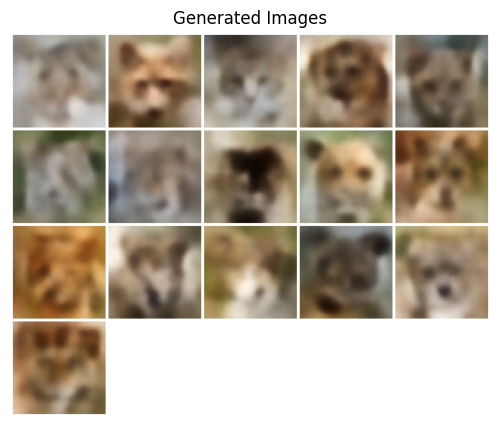

In [59]:
num_images = 16
latent_dim = 512  # Adjust based on your model
generated_images = generate_images(model, latent_dim, num_images, device).to("cpu")

# Visualize generated images
grid = make_grid(generated_images * 0.5 + 0.5, nrow=5, normalize=True, pad_value=1)
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("Generated Images")
plt.show()

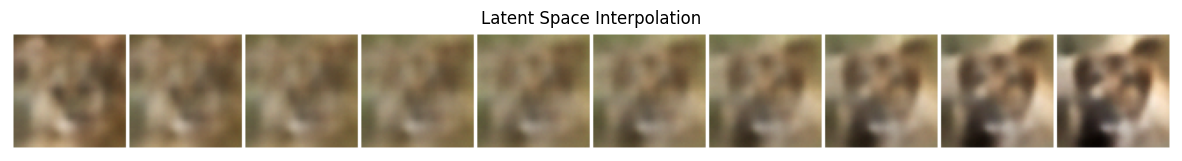

In [60]:
num_steps = 10  # Number of interpolation steps
visualize_latent_interpolation(model, latent_dim, num_steps, device)

In [61]:
def visualize_latent_interpolation_grid(model, latent_dim, num_steps, device):
    """
    Visualize interpolations in the latent space between four random points as a grid.

    Args:
        model: Trained VAE model.
        latent_dim: Dimensionality of the latent space.
        num_steps: Number of interpolation steps per axis.
        device: Device to use (e.g., 'cuda' or 'cpu').

    Returns:
        None (displays a plot of interpolated images).
    """
    model.eval()
    with torch.no_grad():
        # Sample four random latent vectors
        z1 = torch.randn(1, latent_dim).to(device)
        z2 = torch.randn(1, latent_dim).to(device)
        z3 = torch.randn(1, latent_dim).to(device)
        z4 = torch.randn(1, latent_dim).to(device)

        # Interpolation weights
        weights = torch.linspace(0, 1, num_steps).to(device)

        # Create grid of interpolated latent vectors
        grid_images = []
        for alpha in weights:
            row = []
            for beta in weights:
                # Bilinear interpolation between four corners
                z = (1 - alpha) * (1 - beta) * z1 + \
                    (1 - alpha) * beta * z2 + \
                    alpha * (1 - beta) * z3 + \
                    alpha * beta * z4
                row.append(model.decoder(z))
            grid_images.append(torch.cat(row, dim=0))

        # Concatenate rows to form the grid
        grid_images = torch.cat(grid_images, dim=0)
        
        # Normalize and prepare for visualization
        grid_images = (grid_images * 0.5 + 0.5).cpu()
        grid = make_grid(grid_images, nrow=num_steps, normalize=True, pad_value=1)

        # Plot the grid
        plt.figure(figsize=(15, 15))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.title("Latent Space Interpolation Grid")
        plt.show()


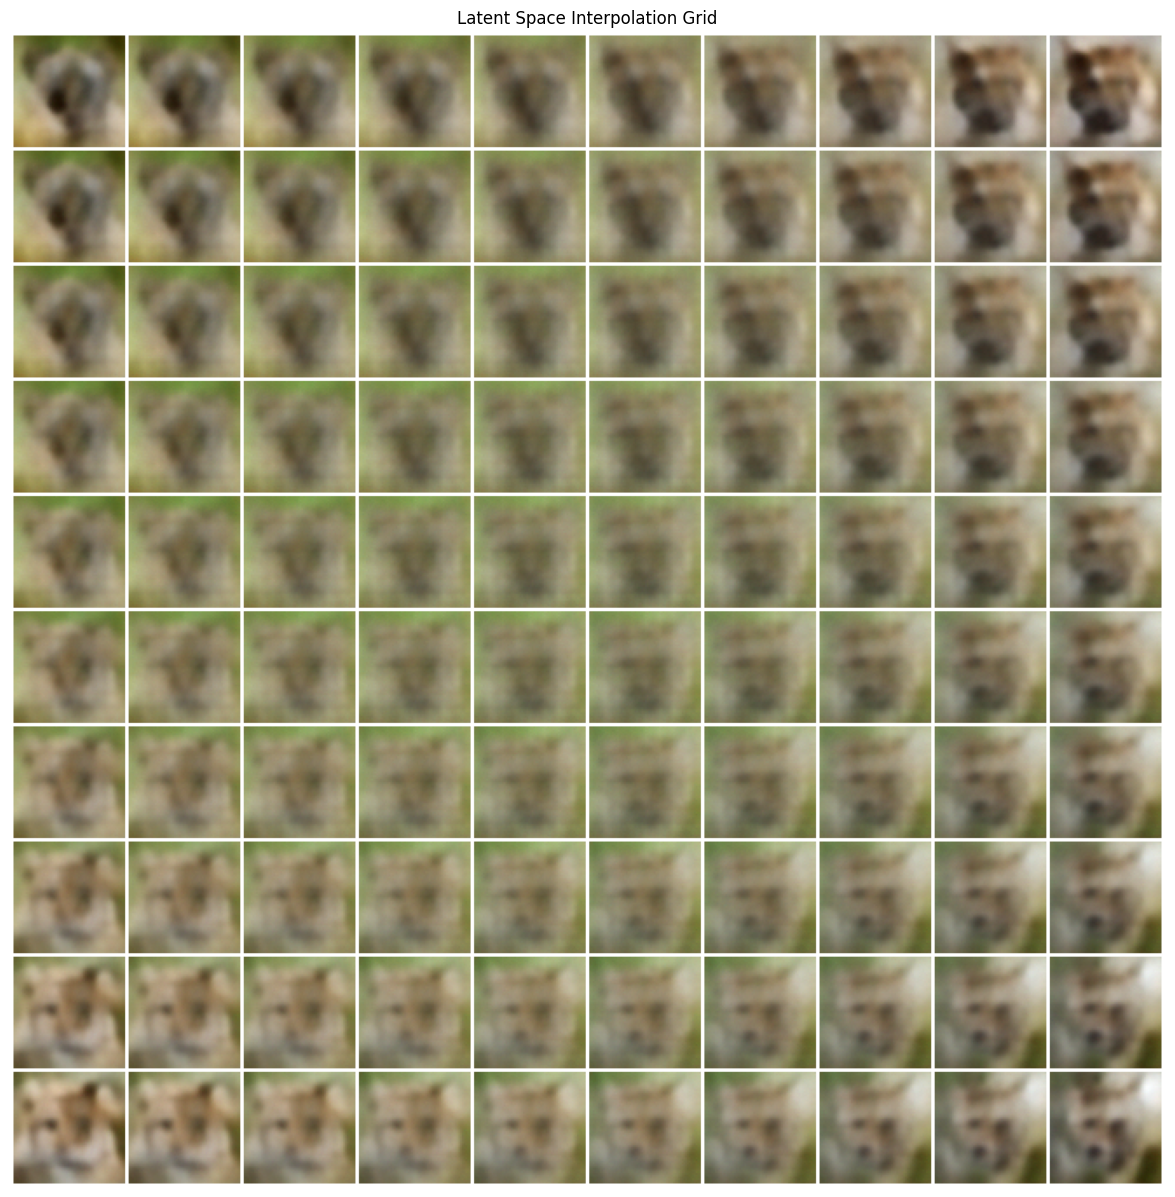

In [62]:
num_steps = 10  # Number of steps per axis in the grid
visualize_latent_interpolation_grid(model, latent_dim, num_steps, device)